# Fitting Height-Diameter relationship from field observations

## Chapman-Richards Function
This is the basic equation that we will fit against our data.  
$  
H = 4.5 + b_0*(1-e^{-b_1*D})^{b_2}
$  
where:  
$4.5$: breast height  
$b_0$: maximum height (asymptote) above breast height  
$b_1$, $b_2$: shape parameters  
$D$: diameter at breast height (in)  
$H$: total tree height (ft)  

## FIA
...

In [1]:
import pandas as pd
import numpy as np
import sqlalchemy

from matplotlib import pyplot as plt
import seaborn as sns
import arviz as az

from sklearn.preprocessing import LabelEncoder

from jax import numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive, init_to_value, 
# from numpyro.infer import init_to_median, init_to_feasible, init_to_sample

In [2]:
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.85"
numpyro.set_platform("gpu")
numpyro.set_host_device_count(3)

In [3]:
# we have three separate databases, one for each state
ORDB = "../../data/raw/FIADB_OR.db"
WADB = "../../data/raw/FIADB_WA.db"
CADB = "../../data/raw/FIADB_CA.db"
ORengine = sqlalchemy.create_engine(f"sqlite:///{ORDB}")
WAengine = sqlalchemy.create_engine(f"sqlite:///{WADB}")
CAengine = sqlalchemy.create_engine(f"sqlite:///{CADB}")

In [4]:
SQL = """
SELECT FVS_TREEINIT_PLOT.PLOT_CN, FVS_TREEINIT_PLOT.TREE_CN, 
       FVS_STANDINIT_PLOT.VARIANT, FVS_STANDINIT_PLOT.LOCATION,
       SPECIES AS FIA_SPCD, DIAMETER AS DBH, HT
FROM FVS_TREEINIT_PLOT
LEFT JOIN FVS_STANDINIT_PLOT 
ON FVS_TREEINIT_PLOT.PLOT_CN = FVS_STANDINIT_PLOT.STAND_CN
WHERE DIAMETER IS NOT NULL AND HT IS NOT NULL AND HTTOPK IS NULL AND VARIANT IS NOT NULL AND LOCATION IS NOT NULL
"""
trees = pd.concat(
    [
        pd.read_sql(SQL, ORengine),
        pd.read_sql(SQL, WAengine),
        pd.read_sql(SQL, CAengine),
    ],
    axis=0,
    ignore_index=True,
)
trees["FIA_SPCD"] = trees["FIA_SPCD"].astype(int)
trees["LOCATION"] = trees["LOCATION"].astype(int)
trees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1139546 entries, 0 to 1139545
Data columns (total 7 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   PLOT_CN   1139546 non-null  object 
 1   TREE_CN   1139546 non-null  object 
 2   VARIANT   1139546 non-null  object 
 3   LOCATION  1139546 non-null  int64  
 4   FIA_SPCD  1139546 non-null  int64  
 5   DBH       1139546 non-null  float64
 6   HT        1139546 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 60.9+ MB


In [5]:
FVS_SPP = "../data/interim/fvs_speciescrosswalk.csv"
fvs_spp = pd.read_csv(FVS_SPP)
fvs_spp.columns = [col.upper() for col in fvs_spp.columns]
fvs_spp = fvs_spp.dropna(subset=["FIA_SPCD"])
fvs_spp["FIA_SPCD"] = fvs_spp["FIA_SPCD"].astype(int)
lookup_fiafvs = fvs_spp.set_index("FIA_SPCD")

SPP_IDX = "../data/interim/fvs_spp_indexes.csv"
spp_idx = pd.read_csv(SPP_IDX).set_index(["VARIANT", "FVS_ALPHA"])
spp_idx.head(20)

VAR_SPP_IDX
VARIANT FVS_ALPHA             
AK      SF                   1
        AF                   2
        YC                   3
        TA                   4
        WS                   5
        LS                   6
        BE                   7
        SS                   8
        LP                   9
        RC                  10
        WH                  11
        MH                  12
        OS                  13
        AD                  14
        RA                  15
        PB                  16
        AB                  17
        BA                  18
        AS                  19
        CW                  20

In [6]:
lookup_fiafvs.head()

USDA_PLANTS_SYMBOL FVS_ALPHA         COMMON_NAME  \
FIA_SPCD                                                    
10                    ABIES        OF         fir species   
21                     ABSH        SH      Shasta red fir   
11                     ABAM        SF  Pacific silver fir   
14                     ABBR        SL     bristlecone fir   
15                     ABCO        WF           white fir   

              SCIENTIFIC_NAME AK_MAPPED_TO BM_MAPPED_TO CA_MAPPED_TO  \
FIA_SPCD                                                               
10                     Abies            SF           GF           WF   
21        Abies x shastensis            OS           OS           SH   
11            Abies amabilis            SF           OS           SH   
14           Abies bracteata            OS           OS           OS   
15            Abies concolor            OS           GF           WF   

         CI_MAPPED_TO CR_MAPPED_TO EC_MAPPED_TO  ... NC_MAPPED_TO  \
FIA_SPCD                                         ...                
10                 AF           AF           GF  ...           WF   
21                 OS           OS           NF  ...           RF   
11                 OS           OS           SF  ...           RF   
14                 OS           OS           WB  ...           OS   
15                 GF           WF           WF  ...           WF   

         NI_MAPPED_TO PN_MAPPED_TO SO_MAPPED_TO TT_MAPPED_TO UT_MAPPED_TO  \
FIA_SPCD                                                                    
10                 GF           SF           WF           AF           AF   
21                 OT           RF           SH           OS           WF   
11                 OT           SF           SF           OS           OS   
14                 OT           OT           OS           OS           OS   
15                 GF           WF           WF           AF           WF   

         WC_MAPPED_TO WS_MAPPED_TO OC_MAPPED_TO OP_MAPPED_TO  
FIA_SPCD                                                      
10                 SF           WF           GF           SF  
21                 RF           RF           SH           RF  
11                 SF           SF           SH           SF  
14                 OT           OS           OS           OT  
15                 WF           WF           GF           WF  

[5 rows x 23 columns]

In [7]:
trees["FVS_SPP"] = np.nan

for var in np.unique(trees.VARIANT):
    filt = trees.VARIANT == var
    trees.loc[filt, "COMMON_NAME"] = lookup_fiafvs.reindex(
        trees.loc[filt, "FIA_SPCD"].values
    )["COMMON_NAME"].values
    trees.loc[filt, "FVS_SPP"] = lookup_fiafvs.reindex(
        trees.loc[filt, "FIA_SPCD"].values
    )[f"{var}_MAPPED_TO"].values

trees["SPP_IDX"] = LabelEncoder().fit_transform(trees["FVS_SPP"])
trees["VAR_SPP_IDX"] = spp_idx.reindex(
    pd.MultiIndex.from_frame(trees[["VARIANT", "FVS_SPP"]])
)["VAR_SPP_IDX"].values
trees["LOCATION_IDX"] = LabelEncoder().fit_transform(trees["LOCATION"])
trees["VARIANT_IDX"] = LabelEncoder().fit_transform(trees["VARIANT"])

trees = trees.dropna(subset=["FVS_SPP", "SPP_IDX"]).copy()
trees.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1139331 entries, 0 to 1139545
Data columns (total 13 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   PLOT_CN       1139331 non-null  object 
 1   TREE_CN       1139331 non-null  object 
 2   VARIANT       1139331 non-null  object 
 3   LOCATION      1139331 non-null  int64  
 4   FIA_SPCD      1139331 non-null  int64  
 5   DBH           1139331 non-null  float64
 6   HT            1139331 non-null  float64
 7   FVS_SPP       1139331 non-null  object 
 8   COMMON_NAME   1139331 non-null  object 
 9   SPP_IDX       1139331 non-null  int64  
 10  VAR_SPP_IDX   1139324 non-null  float64
 11  LOCATION_IDX  1139331 non-null  int64  
 12  VARIANT_IDX   1139331 non-null  int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 121.7+ MB


In [8]:
trees.groupby(by=["FVS_SPP"])["TREE_CN"].count()

FVS_SPP
AF    24152
AS     1939
BD      104
BL     6722
BM    10577
      ...  
WL    14585
WN        2
WO     7367
WP     5461
YC     2539
Name: TREE_CN, Length: 76, dtype: int64

In [9]:
pd.pivot_table(
    trees.groupby(by=["VARIANT", "FVS_SPP"])["TREE_CN"].count().reset_index(),
    index="FVS_SPP",
    columns="VARIANT",
).astype("Int64")

TREE_CN                                                               \
VARIANT      AK    BM    CA    CI    CR     EC    IE    NC    PN    SO    WC   
FVS_SPP                                                                        
AF         <NA>  5125  <NA>  <NA>  <NA>  13637  1663  <NA>   871   461  2395   
AS         <NA>    65    24  <NA>  <NA>    422   303  <NA>  <NA>   588     4   
BD         <NA>  <NA>  <NA>  <NA>  <NA>   <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
BL         <NA>  <NA>  5582  <NA>  <NA>   <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
BM         <NA>  <NA>  1172  <NA>  <NA>    263  <NA>  <NA>  4968     3  3836   
...         ...   ...   ...   ...   ...    ...   ...   ...   ...   ...   ...   
WL         <NA>  5499  <NA>  <NA>  <NA>   5729  3297  <NA>  <NA>    60  <NA>   
WN         <NA>  <NA>     2  <NA>  <NA>   <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
WO         <NA>  <NA>  2422  <NA>  <NA>   2243  <NA>  <NA>   615   770  1317   
WP         <NA>    19   695  <NA>  <NA>    651   302  <NA>    62   899  1198   
YC         <NA>  <NA>  <NA>  <NA>  <NA>    443  <NA>  <NA>   224  <NA>  1872   

               
VARIANT    WS  
FVS_SPP        
AF       <NA>  
AS        533  
BD        104  
BL       1140  
BM        335  
...       ...  
WL       <NA>  
WN       <NA>  
WO       <NA>  
WP       1635  
YC       <NA>  

[76 rows x 12 columns]

In [10]:
# xs = np.linspace(0,100,1000)
# plt.plot(xs, np.exp(dist.Gamma(concentration=(200./150.)**2, rate=200./(150.**2)).log_prob(xs)))
# plt.plot(xs, np.exp(dist.InverseGamma(0.1, 0.1).log_prob(xs)))

In [11]:
def predict_height(locations=None, dbh=None, ht=None):
    unique_locations = np.unique(trees.LOCATION)
    num_locations = len(unique_locations)

    b0_mu = numpyro.sample(
        "b0_mu",
        dist.Gamma(concentration=(200.0 / 150.0) ** 2, rate=200.0 / (150.0**2)),
    )
    b0_sd = numpyro.sample("b0_sd", dist.InverseGamma(1.0, 20.0))
    b1_mu = numpyro.sample(
        "b1_mu", dist.Gamma(concentration=(0.1 / 0.1) ** 2, rate=0.1 / (0.1**2))
    )
    b1_sd = numpyro.sample("b1_sd", dist.InverseGamma(0.1, 0.1))
    b2_mu = numpyro.sample(
        "b2_mu", dist.Gamma(concentration=(1.5 / 1.0) ** 2, rate=1.5 / (1.0**2))
    )
    b2_sd = numpyro.sample("b2_sd", dist.InverseGamma(1.0, 3.0))

    with numpyro.plate("plate_location", size=num_locations):
        b0 = numpyro.sample(
            "b0",
            dist.Gamma(concentration=(b0_mu / b0_sd) ** 2, rate=b0_mu / (b0_sd**2)),
        )
        b1 = numpyro.sample(
            "b1",
            dist.Gamma(concentration=(b1_mu / b1_sd) ** 2, rate=b1_mu / (b1_sd**2)),
        )
        b2 = numpyro.sample(
            "b2",
            dist.Gamma(concentration=(b2_mu / b2_sd) ** 2, rate=b2_mu / (b2_sd**2)),
        )

    mu = 4.5 + b0[locations] * (1 - jnp.exp(-b1[locations] * dbh)) ** b2[locations]
    pred = numpyro.deterministic("pred", mu)
    sigma = numpyro.sample("sigma", dist.InverseGamma(1.0, 20.0))
    hetero = numpyro.sample("hetero", dist.Uniform(0, 10))

    numpyro.sample("obs", dist.Normal(loc=mu, scale=sigma + hetero * dbh), obs=ht)

In [12]:
INIT_VALS = init_to_value(
    values={
        "b0": jnp.full(53, 100.0),
        "b1": jnp.full(53, 0.05),
        "b2": jnp.full(53, 1.25),
        "b0_mu": jnp.array(100.0),
        "b1_mu": jnp.array(0.05),
        "b2_mu": jnp.array(1.25),
        "b0_sd": jnp.array(10.0),
        "b1_sd": jnp.array(0.01),
        "b2_sd": jnp.array(0.25),
    }
)

In [13]:
def train(model, guide, data, lr=0.0005, n_steps=50000, seed=42):
    optimizer = numpyro.optim.Adam(step_size=lr)
    # optimizer = numpyro.optim.Minimize()
    svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
    result = svi.run(
        random.PRNGKey(seed),
        n_steps,
        locations=data.LOCATION_IDX.values,
        dbh=data.DBH.values,
        ht=data.HT.values,
    )
    return result

In [14]:
def fit_model(model, data, num_chains=3, num_warmup=5000, num_samples=1000, seed=0):
    rng_key = random.PRNGKey(seed)

    # svi_result = train(model=model,
    #                    guide=autoguide.AutoDelta(model, init_loc_fn=INIT_VALS),
    #                    data=data
    #                   )

    kernel = NUTS(
        model,
        init_strategy=INIT_VALS,
        # init_to_value(
        # values={key.replace('_auto_loc',''):value for (key, value) in svi_result.params.items()})
    )
    mcmc = MCMC(
        kernel,
        num_chains=num_chains,
        num_warmup=num_warmup,
        num_samples=num_samples,
        progress_bar=True,
    )

    mcmc.run(
        rng_key,
        locations=data.LOCATION_IDX.values,
        dbh=data.DBH.values,
        ht=data.HT.values,
    )

    mcmc.print_summary()

    return mcmc

In [15]:
results = {}

for spp, count in (
    trees.groupby(by=["FIA_SPCD"])["TREE_CN"]
    .count()
    .sort_values(ascending=False)
    .iteritems()
):
    if count > 5000:
        n = 5000
        data = trees.loc[trees.FIA_SPCD == spp].sample(n).copy()
    else:
        n = count
        data = trees.loc[trees.FIA_SPCD == spp].copy()
    spp_name = lookup_fiafvs.loc[spp, "COMMON_NAME"]
    print(f"Fitting {spp_name} with {n:,.0f} samples")

    mcmc = fit_model(predict_height, data)
    results[spp] = mcmc

Fitting Douglas-fir with 5,000 samples


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    170.79     17.14    169.48    142.96    198.77    887.61      1.00
     b0[1]    183.96     23.89    182.73    144.84    221.93   2524.96      1.00
     b0[2]    183.93     23.08    183.72    145.77    221.00   2232.93      1.00
     b0[3]    183.61     23.29    182.63    146.04    220.99   2446.22      1.00
     b0[4]    183.81     23.67    183.23    146.77    221.97   2067.16      1.00
     b0[5]    183.68     22.56    182.63    145.17    218.34   1706.88      1.00
     b0[6]    188.35     16.38    187.35    162.18    214.98   1282.57      1.00
     b0[7]    183.48     23.81    182.73    145.84    223.03   2179.26      1.00
     b0[8]    184.72     13.53    184.05    161.61    204.98    990.68      1.00
     b0[9]    173.25     17.82    172.46    143.71    201.30    997.07      1.00
    b0[10]    187.01     18.43    186.41    157.86    217.75   1456.46      1.00
    b0[11]    172.20     13

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    165.55     10.00    165.59    149.37    182.33    592.31      1.00
     b0[1]    166.85     11.74    166.49    146.75    183.79    710.82      1.00
     b0[2]    166.69     11.17    166.43    148.76    185.55    654.22      1.00
     b0[3]    166.72     10.96    166.42    147.94    183.57    645.04      1.00
     b0[4]    166.91     11.71    166.47    148.71    186.25    670.17      1.00
     b0[5]    166.90     11.22    166.82    148.73    184.60    660.26      1.00
     b0[6]    181.20     12.10    179.87    162.17    200.04    255.95      1.01
     b0[7]    170.05     10.65    169.30    151.79    186.38    484.19      1.00
     b0[8]    167.78      9.46    167.42    151.53    182.22    436.18      1.00
     b0[9]    164.48      9.56    164.50    148.61    179.42    508.46      1.00
    b0[10]    166.65     11.40    166.72    147.70    184.51    552.45      1.00
    b0[11]    166.68     10

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     93.78      7.31     93.05     82.62    105.76    633.17      1.00
     b0[1]     86.61      8.93     86.23     72.55    100.99   1717.15      1.00
     b0[2]     86.41      8.06     86.30     72.26     98.37   1633.34      1.00
     b0[3]     80.74      7.12     81.04     69.23     92.58    598.11      1.00
     b0[4]     86.62      8.53     86.47     71.82     98.94   1550.69      1.00
     b0[5]     86.45      8.25     86.20     71.68     98.32   1567.75      1.00
     b0[6]     85.99      6.56     85.81     75.30     96.95   1272.29      1.00
     b0[7]     83.11      6.75     83.01     72.78     94.54    988.17      1.00
     b0[8]     86.67      7.50     86.25     74.42     98.50   1393.48      1.00
     b0[9]     88.01      6.70     87.64     76.39     97.85   1416.42      1.00
    b0[10]     86.51      8.72     86.25     73.10    100.40   1523.50      1.00
    b0[11]     86.59      8

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    170.41     10.57    170.00    152.99    188.26   1320.55      1.00
     b0[1]    167.71     12.10    167.56    149.70    188.34   1293.08      1.00
     b0[2]    167.74     11.65    167.91    147.86    185.55   1312.29      1.00
     b0[3]    167.74     11.55    167.90    149.26    186.77   1219.77      1.00
     b0[4]    167.56     12.19    168.06    147.39    187.37   1311.94      1.00
     b0[5]    167.81     11.82    168.02    148.15    187.27   1454.84      1.00
     b0[6]    167.98     12.04    168.18    148.46    186.51   1451.57      1.00
     b0[7]    167.83     12.06    167.96    147.05    185.75   1257.67      1.00
     b0[8]    168.11     11.71    168.13    149.08    186.80   1278.12      1.00
     b0[9]    167.96     12.04    167.94    149.95    188.86    941.99      1.00
    b0[10]    167.70     12.32    168.02    147.77    187.81   1089.26      1.00
    b0[11]    167.93     11

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    156.24     19.74    155.28    124.10    187.28   2904.71      1.00
     b0[1]    156.26     20.19    155.15    123.80    187.72   1984.48      1.00
     b0[2]    156.23     19.32    155.95    123.97    186.32   2594.65      1.00
     b0[3]    144.37     15.34    143.55    119.04    169.01   1454.95      1.00
     b0[4]    142.05     17.85    142.40    115.60    173.98   1081.87      1.00
     b0[5]    155.63     18.29    154.75    127.41    186.42   1784.99      1.00
     b0[6]    170.86     13.23    169.70    150.18    191.87   1266.77      1.00
     b0[7]    144.13     15.15    143.70    118.88    168.20   1087.11      1.00
     b0[8]    157.46      9.76    156.78    141.78    173.15   1126.86      1.00
     b0[9]    145.59      9.31    144.75    130.20    160.02   1014.89      1.00
    b0[10]    147.45     18.27    147.11    118.11    178.36   1303.70      1.00
    b0[11]    150.82     15

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    140.93     11.74    141.00    121.71    159.70   1565.17      1.00
     b0[1]    141.04     12.03    140.93    122.78    160.86   1387.60      1.00
     b0[2]    140.96     11.72    141.22    122.75    161.02   1684.29      1.00
     b0[3]    141.08     11.62    140.98    122.35    159.72   1538.47      1.00
     b0[4]    141.02     11.79    141.30    120.57    158.93   1488.13      1.00
     b0[5]    141.01     11.70    141.17    122.69    160.24   1495.82      1.00
     b0[6]    141.03     11.39    141.01    122.11    158.96   1610.83      1.00
     b0[7]    141.11     11.87    140.62    122.98    160.83   1665.66      1.00
     b0[8]    141.19     11.87    140.95    122.61    159.98   1428.79      1.00
     b0[9]    140.98     11.59    140.95    120.57    158.84   1429.46      1.00
    b0[10]    141.20     11.91    141.28    121.20    160.16   1169.54      1.00
    b0[11]    141.18     12

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    148.66      7.89    148.19    136.18    161.61   1257.13      1.00
     b0[1]    145.21     12.77    144.47    125.24    166.35   1914.39      1.00
     b0[2]    145.36     12.32    145.05    123.51    163.41   2012.53      1.00
     b0[3]    145.10     12.15    144.51    126.30    165.55   1859.71      1.00
     b0[4]    145.26     12.76    144.88    123.40    163.27   1866.77      1.00
     b0[5]    145.22     11.89    144.64    127.46    165.20   1635.12      1.00
     b0[6]    145.28     12.35    144.61    126.60    165.71   1762.77      1.00
     b0[7]    145.07     12.28    144.59    124.19    163.44   1922.31      1.00
     b0[8]    144.86     12.27    144.70    124.68    163.54   1649.24      1.00
     b0[9]    145.08     12.33    144.64    125.01    164.10   1891.77      1.00
    b0[10]    145.11     12.80    144.63    124.72    166.89   1575.81      1.00
    b0[11]    144.77     10

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     95.47      9.60     94.94     80.40    112.05    915.42      1.00
     b0[1]     95.87     10.11     95.33     81.02    112.65   1027.96      1.00
     b0[2]     95.62      9.79     95.10     79.29    110.57    844.50      1.00
     b0[3]     95.58      9.80     95.17     79.82    110.77    819.67      1.00
     b0[4]     95.72      9.84     95.35     80.02    111.39    893.97      1.00
     b0[5]     95.52      9.62     95.06     81.54    112.03    988.38      1.00
     b0[6]     95.43      8.64     95.05     80.84    108.59    734.09      1.00
     b0[7]     95.99     10.36     95.58     78.39    111.53   1039.78      1.00
     b0[8]     92.87      7.45     92.50     80.74    104.70    464.03      1.00
     b0[9]     93.70      8.36     93.35     79.76    106.95    739.79      1.00
    b0[10]    100.85      6.59    100.30     90.21    111.13    535.61      1.00
    b0[11]     95.97      5

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    124.50      7.78    123.97    112.22    137.33    984.78      1.00
     b0[1]    148.05     24.57    146.57    107.72    186.25   2120.11      1.00
     b0[2]    148.22     23.86    147.65    112.38    189.24   2628.64      1.00
     b0[3]    147.88     23.00    146.55    111.91    185.73   2471.03      1.00
     b0[4]    148.48     23.32    147.81    113.09    187.76   2797.72      1.00
     b0[5]    147.96     23.32    147.08    111.59    187.76   2317.11      1.00
     b0[6]    147.52     23.44    146.35    109.11    183.79   3297.71      1.00
     b0[7]    148.51     23.71    147.56    111.49    187.60   3065.55      1.00
     b0[8]    148.38     24.43    147.23    112.07    188.91   2540.32      1.00
     b0[9]    147.84     23.55    146.53    107.45    182.99   2159.23      1.00
    b0[10]    148.05     24.26    146.78    108.78    187.49   1983.30      1.00
    b0[11]    147.78     24

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     79.22      9.52     78.88     64.97     95.28    315.48      1.00
     b0[1]     79.30      9.76     78.81     62.76     93.75    348.73      1.00
     b0[2]     79.33      9.33     78.82     64.67     94.99    301.95      1.00
     b0[3]     79.40      9.63     79.10     63.62     94.15    303.37      1.00
     b0[4]     74.77      9.38     75.01     59.56     90.46    252.21      1.00
     b0[5]     78.55      8.89     78.20     65.17     94.48    281.32      1.00
     b0[6]     85.32      8.75     84.20     71.32     98.58    234.71      1.01
     b0[7]     76.15      9.65     76.36     61.37     93.54    269.82      1.00
     b0[8]     79.75      8.33     79.12     65.95     92.55    253.31      1.00
     b0[9]     78.73      8.47     78.42     64.07     91.11    269.00      1.00
    b0[10]     78.50      8.73     78.07     63.51     91.83    261.83      1.00
    b0[11]     81.11      7

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    113.90     12.28    113.55     94.57    134.01   1158.07      1.00
     b0[1]    119.42     18.16    118.19     89.99    147.38   2653.31      1.00
     b0[2]    119.03     16.61    118.79     91.79    145.32   2147.56      1.00
     b0[3]    104.43     13.74    104.30     83.44    128.72    857.60      1.00
     b0[4]    119.49     16.99    119.34     92.09    145.51   2418.02      1.00
     b0[5]    118.87     16.47    118.17     91.48    144.73   2031.86      1.00
     b0[6]    104.84     12.29    103.96     84.92    124.37    715.57      1.00
     b0[7]    117.08     15.05    116.54     92.29    140.10   2243.54      1.00
     b0[8]    119.86     10.46    119.06    102.71    135.39   1230.71      1.00
     b0[9]    109.19     13.11    108.82     86.42    128.59   1104.72      1.00
    b0[10]    119.09     17.22    118.32     92.23    147.04   2037.86      1.00
    b0[11]    119.39     17

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     96.89     10.63     97.15     79.19    113.86    826.13      1.00
     b0[1]    100.63     11.73    100.57     81.05    119.27   1619.06      1.00
     b0[2]    100.58     11.24    100.49     80.70    117.37   1125.06      1.00
     b0[3]    100.49     11.24    100.48     82.08    118.05   1060.26      1.00
     b0[4]    100.60     11.34    100.67     81.68    117.67   1251.22      1.00
     b0[5]    100.59     10.89    100.73     80.83    116.72   1067.27      1.00
     b0[6]    100.59     11.28    100.47     81.71    117.50   1410.77      1.00
     b0[7]    100.57     11.54    100.33     81.45    118.80   1455.14      1.00
     b0[8]    101.94     10.09    101.70     85.12    117.48   1377.38      1.00
     b0[9]     99.30     10.80     99.27     81.43    116.54   1156.64      1.00
    b0[10]     97.38     10.94     97.65     79.13    114.37    838.84      1.00
    b0[11]    101.44      9

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    101.30      7.63    100.77     88.86    113.21   1576.90      1.00
     b0[1]     92.61     10.88     92.07     75.89    109.64   2309.06      1.00
     b0[2]     92.45     10.26     92.43     76.09    109.97   2108.59      1.00
     b0[3]     92.38      9.98     92.06     76.78    109.40   2531.62      1.00
     b0[4]     92.78     10.52     92.69     76.02    109.55   2108.71      1.00
     b0[5]     92.42     10.56     92.25     76.15    109.82   2229.55      1.00
     b0[6]     92.48     10.08     92.11     76.62    109.01   2170.18      1.00
     b0[7]     92.50     10.62     92.22     75.36    109.01   2322.58      1.00
     b0[8]     92.74     10.32     92.53     76.50    109.98   1907.36      1.00
     b0[9]     92.67     10.53     92.67     75.08    108.72   2094.09      1.00
    b0[10]     92.56     10.56     92.39     75.21    109.23   2031.72      1.00
    b0[11]     92.42     10

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    159.16     27.06    157.59    119.15    205.75   2800.27      1.00
     b0[1]    159.85     26.65    158.46    115.52    200.10   2416.17      1.00
     b0[2]    159.11     26.70    157.78    116.81    202.20   3213.30      1.00
     b0[3]    159.14     25.86    157.70    114.98    199.11   2296.05      1.00
     b0[4]    156.99     24.82    156.32    119.85    201.88   2111.41      1.00
     b0[5]    146.36     21.42    145.38    111.59    180.95   1717.09      1.00
     b0[6]    165.60     15.03    164.09    142.02    189.93   1479.34      1.00
     b0[7]    149.03     21.00    147.81    116.31    183.77   1662.30      1.00
     b0[8]    159.75     17.22    158.06    132.02    186.16   1174.63      1.00
     b0[9]    159.37     15.19    157.95    136.49    184.29   1402.66      1.00
    b0[10]    158.84     27.68    157.33    115.98    204.85   2540.25      1.00
    b0[11]    159.86     19

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     39.03      4.80     38.89     31.20     46.78   2734.31      1.00
     b0[1]     39.04      4.94     38.86     30.45     46.71   3135.17      1.00
     b0[2]     36.77      4.45     36.74     29.78     44.22   2334.94      1.00
     b0[3]     40.94      2.75     40.79     36.24     45.26   1778.68      1.00
     b0[4]     39.02      5.01     38.81     31.03     46.96   2449.85      1.00
     b0[5]     38.94      4.75     38.74     30.89     46.13   2916.68      1.00
     b0[6]     36.51      3.93     36.51     29.65     42.45   2197.18      1.00
     b0[7]     35.32      4.09     35.22     28.92     42.14   1221.20      1.00
     b0[8]     39.21      2.83     39.02     34.65     43.75   1404.35      1.00
     b0[9]     35.94      2.63     35.79     31.45     39.86   1582.05      1.00
    b0[10]     39.11      4.93     38.90     31.84     47.74   3141.91      1.00
    b0[11]     38.99      4

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    124.52      4.69    124.32    116.93    132.00    683.20      1.00
     b0[1]    133.04      8.87    132.67    118.40    146.86   2715.74      1.00
     b0[2]    132.88      8.37    132.87    119.36    146.70   2306.84      1.00
     b0[3]    132.98      8.16    132.80    119.27    145.43   2390.65      1.00
     b0[4]    132.94      8.74    132.70    118.68    146.03   2465.00      1.00
     b0[5]    133.00      8.57    132.86    119.46    146.75   1801.04      1.00
     b0[6]    132.87      8.44    132.61    118.44    145.84   2234.84      1.00
     b0[7]    133.05      8.39    132.84    119.01    145.55   2601.32      1.00
     b0[8]    133.09      8.25    132.83    119.82    146.26   2238.39      1.00
     b0[9]    132.97      8.40    132.74    119.27    146.14   2185.15      1.00
    b0[10]    132.96      8.58    132.88    118.66    146.15   1867.36      1.00
    b0[11]    132.95      8

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     78.26      8.87     77.74     63.50     92.54   1906.03      1.00
     b0[1]     78.55      9.45     77.76     62.29     92.31   1617.99      1.00
     b0[2]     78.28      9.06     77.88     64.17     93.46   1629.86      1.00
     b0[3]     78.34      8.94     77.85     64.02     92.10   1579.67      1.00
     b0[4]     78.41      9.19     77.99     63.10     92.20   2087.57      1.00
     b0[5]     78.33      9.22     77.71     64.31     94.22   1481.96      1.00
     b0[6]     81.81      8.52     80.91     68.49     94.89    953.20      1.00
     b0[7]     78.57      9.56     78.07     63.80     93.77   1707.15      1.00
     b0[8]     78.37      6.16     77.84     67.78     87.46    641.10      1.00
     b0[9]     73.13      7.31     73.03     61.02     85.23   1300.37      1.00
    b0[10]     77.24      5.61     76.95     68.31     86.63   1060.85      1.00
    b0[11]     69.89      4

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     78.10      7.66     78.01     66.08     91.16   1082.16      1.00
     b0[1]     78.18      7.98     77.72     64.23     90.05   1332.30      1.00
     b0[2]     78.08      7.61     78.11     66.00     91.18   1018.60      1.00
     b0[3]     78.03      7.47     77.82     65.83     89.68    968.33      1.00
     b0[4]     78.29      7.84     77.97     65.62     90.35   1104.29      1.00
     b0[5]     75.83      7.44     75.94     63.91     88.37    614.95      1.00
     b0[6]     81.71      5.40     81.22     73.02     90.04    818.77      1.00
     b0[7]     78.23      7.92     78.02     64.96     90.87   1165.86      1.00
     b0[8]     79.22      6.25     78.75     68.70     88.70    626.89      1.00
     b0[9]     82.05      5.72     81.56     72.57     91.35    765.22      1.00
    b0[10]     74.39      7.42     74.73     62.10     86.22    490.28      1.00
    b0[11]     74.00      4

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    124.95      6.91    124.81    113.47    136.11   1703.84      1.00
     b0[1]    133.20     12.11    132.50    113.74    153.11   3220.66      1.00
     b0[2]    133.31     11.48    133.29    116.20    153.11   2672.06      1.00
     b0[3]    133.21     11.79    132.77    114.30    152.88   2540.80      1.00
     b0[4]    133.49     12.48    132.94    112.30    152.04   2906.58      1.00
     b0[5]    132.99     11.53    132.63    113.54    150.63   2193.73      1.00
     b0[6]    133.29     11.51    132.51    115.69    152.96   2708.84      1.00
     b0[7]    133.39     12.21    132.78    114.81    153.68   3206.70      1.00
     b0[8]    131.70     10.97    131.43    112.98    148.39   2442.30      1.00
     b0[9]    133.15     12.05    132.93    113.68    152.22   2813.32      1.00
    b0[10]    133.45     11.84    132.96    114.14    151.72   2300.53      1.00
    b0[11]    133.18     11

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    141.77     22.48    140.97    104.43    175.90   2805.54      1.00
     b0[1]    141.74     23.45    140.29    103.82    178.37   2756.22      1.00
     b0[2]    141.89     21.90    141.03    104.48    176.44   2800.93      1.00
     b0[3]    111.85     12.37    110.54     90.97    130.26    715.29      1.00
     b0[4]    142.60     22.01    141.85    106.78    176.48   2915.51      1.00
     b0[5]    141.69     22.10    139.99    105.08    177.60   2616.77      1.00
     b0[6]    136.10      6.19    135.86    126.31    146.29   1664.32      1.00
     b0[7]    140.28     14.32    139.04    118.98    164.81   1371.50      1.00
     b0[8]    137.99     14.90    136.90    113.63    161.76   1557.12      1.00
     b0[9]    133.21      5.95    132.88    123.71    142.84   1420.85      1.00
    b0[10]    141.50     23.08    140.50    103.84    177.98   2645.67      1.00
    b0[11]    147.83     10

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    145.65     28.19    143.47     99.96    189.81   3593.71      1.00
     b0[1]    145.96     28.04    143.44     98.90    188.23   2648.38      1.00
     b0[2]    144.92     26.14    143.55    102.10    186.21   3636.76      1.00
     b0[3]    117.76     13.79    116.35     95.86    139.37   1039.32      1.00
     b0[4]    132.85     22.68    131.63     95.82    169.48   1546.60      1.00
     b0[5]    145.30     26.58    143.28    103.72    188.33   2883.40      1.00
     b0[6]    126.10      8.00    125.48    113.02    138.55   1243.76      1.00
     b0[7]    131.38     16.78    129.40    106.32    159.17   1286.48      1.00
     b0[8]    135.81     16.69    134.28    108.34    161.76   1841.55      1.00
     b0[9]    142.94     10.84    141.87    125.35    159.14   1962.48      1.00
    b0[10]    123.54     16.56    121.68     97.14    148.65    883.60      1.00
    b0[11]    143.59     21

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    212.66     51.82    210.08    135.09    296.67   1285.17      1.00
     b0[1]    214.04     55.34    210.65    137.25    292.16    977.56      1.00
     b0[2]    212.86     53.10    210.95    124.55    285.47    994.63      1.00
     b0[3]    211.67     47.66    210.18    136.37    288.21    864.47      1.00
     b0[4]    213.37     50.11    211.32    140.60    292.83    886.25      1.00
     b0[5]    213.09     54.40    210.42    121.51    284.58   1204.03      1.00
     b0[6]    211.34     49.07    210.31    137.62    289.91    627.90      1.00
     b0[7]    212.89     54.69    210.76    134.43    296.69    803.40      1.00
     b0[8]    213.21     49.46    210.87    131.65    286.62    693.82      1.00
     b0[9]    213.59     54.82    211.14    129.62    293.42   1257.64      1.00
    b0[10]    185.05      7.86    184.48    172.96    197.76    644.07      1.00
    b0[11]    223.24     14

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     96.21     10.58     96.37     79.74    114.44   1777.92      1.00
     b0[1]     96.51     10.86     96.20     78.47    113.67   1570.11      1.00
     b0[2]     96.44     10.80     96.66     78.46    113.75   1618.37      1.00
     b0[3]     96.44     10.49     96.25     78.68    112.97   1345.19      1.00
     b0[4]     93.79      9.09     93.93     78.85    108.53    940.84      1.00
     b0[5]     96.44     10.44     96.35     78.74    112.46   1351.66      1.00
     b0[6]     95.74      8.00     95.43     82.98    108.75    943.53      1.00
     b0[7]     96.58     11.08     96.56     78.87    114.86   1589.53      1.00
     b0[8]     88.94      9.13     88.62     73.44    103.16    513.11      1.00
     b0[9]     99.70      8.50     99.36     84.53    112.47   1711.17      1.00
    b0[10]     90.48      9.68     90.48     75.09    107.03    592.21      1.00
    b0[11]     91.41      8

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     50.01     17.01     47.71     21.99     73.83   3192.06      1.00
     b0[1]     50.03     17.61     47.86     23.89     79.42   3416.46      1.00
     b0[2]     49.88     16.22     48.42     21.84     73.45   3469.53      1.00
     b0[3]     50.02     16.67     47.85     23.55     75.72   3768.81      1.00
     b0[4]     49.99     16.95     48.68     24.22     76.14   3444.54      1.00
     b0[5]     49.77     16.56     47.97     23.73     75.44   2466.55      1.00
     b0[6]     49.80     16.39     47.89     22.06     72.79   3785.37      1.00
     b0[7]     50.07     17.05     47.97     22.21     74.78   3730.92      1.00
     b0[8]     40.60      4.96     39.74     32.99     47.88    915.52      1.00
     b0[9]     47.65      8.05     46.82     34.01     59.09   1146.88      1.00
    b0[10]     43.85     10.20     42.58     28.56     59.47   1905.31      1.00
    b0[11]     47.87      3

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    179.09     29.37    178.49    132.57    226.88   3473.69      1.00
     b0[1]    179.41     31.21    178.01    129.64    228.94   3574.60      1.00
     b0[2]    179.11     29.64    178.58    127.46    223.71   2570.06      1.00
     b0[3]    179.89     28.14    179.03    135.75    226.61   3542.89      1.00
     b0[4]    160.67     24.78    159.72    119.46    199.90   1087.05      1.00
     b0[5]    178.85     29.20    178.66    130.38    224.37   2450.53      1.00
     b0[6]    184.32     13.83    182.85    162.04    206.04   1616.18      1.00
     b0[7]    179.15     29.88    177.58    131.06    226.56   3998.71      1.00
     b0[8]    191.22     12.12    190.15    172.10    210.46   1776.12      1.00
     b0[9]    185.20     13.95    183.94    164.09    207.75   1301.67      1.00
    b0[10]    160.85     28.07    160.09    116.25    206.47   1168.80      1.00
    b0[11]    170.51     16

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    137.63     16.89    137.18    109.74    163.67   3308.43      1.00
     b0[1]    137.57     16.83    137.30    112.66    167.10   3524.28      1.00
     b0[2]    137.57     17.00    136.99    111.05    164.05   3001.12      1.00
     b0[3]    137.26     16.43    136.49    110.18    162.77   3091.56      1.00
     b0[4]    137.61     16.96    137.18    107.36    162.86   3274.48      1.00
     b0[5]    137.15     15.86    137.08    110.83    162.33   2990.10      1.00
     b0[6]    137.63     16.11    137.22    112.68    165.05   3267.90      1.00
     b0[7]    137.37     16.88    137.00    109.59    163.22   3430.59      1.00
     b0[8]    143.20      7.58    142.52    130.33    154.75   1155.41      1.00
     b0[9]    133.71     13.37    133.90    111.95    156.27   1522.56      1.00
    b0[10]    137.32     16.79    136.93    110.26    163.85   3078.32      1.00
    b0[11]    137.45     16

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     42.20      5.85     41.86     33.02     51.84   1692.97      1.00
     b0[1]     42.26      6.22     41.77     32.27     52.27   1763.24      1.00
     b0[2]     42.29      6.07     41.99     32.73     52.27   1530.05      1.00
     b0[3]     42.16      6.08     42.00     32.57     51.69   1770.24      1.00
     b0[4]     42.30      5.95     42.22     31.94     51.12   1723.38      1.00
     b0[5]     41.71      5.84     41.39     31.97     50.67   1283.79      1.00
     b0[6]     44.82      4.79     44.39     37.73     52.40    816.29      1.00
     b0[7]     42.35      6.01     42.04     31.97     51.20   1339.32      1.00
     b0[8]     42.29      6.05     41.98     33.38     52.19   1531.49      1.00
     b0[9]     43.86      3.82     43.49     37.44     49.49    918.50      1.00
    b0[10]     39.77      2.48     39.61     35.64     43.56    906.33      1.00
    b0[11]     46.23      3

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    155.50     23.41    155.58    118.99    194.97   1210.10      1.00
     b0[1]    155.02     24.60    155.28    114.57    193.38   1208.35      1.00
     b0[2]    155.39     23.70    155.22    116.53    193.19   1150.08      1.00
     b0[3]    155.43     23.20    155.72    118.06    194.02   1196.37      1.00
     b0[4]    155.34     23.80    154.92    115.75    192.53   1469.01      1.00
     b0[5]    155.51     23.52    155.41    116.46    191.55   1059.89      1.00
     b0[6]    154.91     23.71    154.62    115.59    191.61   1039.95      1.00
     b0[7]    155.73     23.91    155.48    120.34    197.06   1376.20      1.00
     b0[8]    157.07     16.74    156.04    130.85    184.93    778.23      1.00
     b0[9]    155.27     24.08    154.61    115.40    193.54   1240.16      1.00
    b0[10]    155.30     24.57    155.37    116.16    196.72   1049.84      1.00
    b0[11]    155.16     24

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     58.30     10.48     57.65     40.82     74.23   1049.10      1.01
     b0[1]     58.18     10.35     57.50     41.56     74.02    904.86      1.00
     b0[2]     58.13      9.90     57.75     42.27     74.12   1080.37      1.01
     b0[3]     58.18      9.93     57.58     41.64     73.37   1071.06      1.01
     b0[4]     60.78      8.53     60.02     45.90     73.27    652.32      1.01
     b0[5]     63.44      7.37     62.52     51.23     74.28    643.14      1.01
     b0[6]     56.09      7.40     55.64     43.71     67.67    489.31      1.01
     b0[7]     58.04     10.11     57.66     43.40     74.12   1136.11      1.01
     b0[8]     58.44     10.49     57.73     42.44     75.29   1057.17      1.01
     b0[9]     53.18      8.17     52.92     40.13     66.25    458.92      1.01
    b0[10]     63.34      7.70     62.31     51.48     75.24    489.96      1.02
    b0[11]     55.71      4

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    132.67      8.17    132.15    119.18    145.32   1542.57      1.00
     b0[1]    122.34     27.26    120.05     79.69    167.72   3658.21      1.00
     b0[2]    122.00     25.13    120.63     82.52    163.62   3402.83      1.00
     b0[3]     96.26      7.60     95.59     83.68    108.03   1941.55      1.00
     b0[4]    122.60     26.11    121.38     79.28    163.07   3806.31      1.00
     b0[5]    122.27     26.30    120.42     80.95    164.63   3408.82      1.00
     b0[6]    103.62      8.51    102.61     90.63    117.12   1341.94      1.00
     b0[7]     94.18      8.60     93.28     80.49    107.99   1792.52      1.00
     b0[8]    122.54      9.84    121.71    106.65    137.80   1579.98      1.00
     b0[9]    110.81      8.40    110.18     96.73    123.36   1452.64      1.00
    b0[10]    122.33     27.23    120.20     80.51    167.52   3523.97      1.00
    b0[11]    122.65     24

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     71.06     15.64     70.61     45.78     94.95   1410.48      1.00
     b0[1]     71.63     16.36     70.45     45.79     95.37   1472.15      1.00
     b0[2]     71.59     15.83     70.97     44.66     94.74   1152.72      1.00
     b0[3]     71.30     15.37     70.76     48.04     97.19   1152.79      1.00
     b0[4]     69.23     11.74     68.62     50.67     88.22    776.84      1.00
     b0[5]     71.09     15.72     70.52     43.31     93.57   1338.13      1.00
     b0[6]     68.80     11.92     68.04     49.28     88.07    697.26      1.00
     b0[7]     71.36     16.07     70.37     43.86     95.41   1237.27      1.00
     b0[8]     64.46     13.99     63.95     40.42     86.24    634.32      1.00
     b0[9]     62.41     12.06     61.80     42.85     81.68    567.94      1.00
    b0[10]     88.18      8.31     87.21     74.54    100.79    754.07      1.00
    b0[11]     88.80      6

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     29.96     13.81     28.05      9.51     49.67   2609.15      1.00
     b0[1]     16.74      2.88     16.34     12.11     21.03   1338.29      1.00
     b0[2]     30.14     13.70     28.22      8.84     48.31   2814.89      1.00
     b0[3]     26.66      1.52     26.53     24.22     29.13    628.07      1.01
     b0[4]     37.56      5.47     36.86     29.02     46.05   1189.42      1.00
     b0[5]     29.70     12.69     28.27      9.36     48.12   2629.35      1.00
     b0[6]     30.34     13.57     28.30     11.21     49.33   1913.69      1.00
     b0[7]     21.67      0.63     21.66     20.63     22.70   1263.83      1.00
     b0[8]     30.23     13.75     28.11     11.48     49.96   2476.29      1.00
     b0[9]     30.19     13.70     28.26      9.31     48.78   2304.91      1.00
    b0[10]     41.49      1.88     41.33     38.25     44.42    979.47      1.00
    b0[11]     30.11     14

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     56.06     13.97     54.66     33.06     77.23   2860.36      1.00
     b0[1]     56.32     15.21     54.65     34.01     80.49   2330.55      1.00
     b0[2]     56.09     13.76     55.05     33.62     77.34   3329.71      1.00
     b0[3]     55.00      6.16     54.40     44.76     64.52   1306.78      1.00
     b0[4]     56.74     14.52     55.65     35.04     78.96   2568.50      1.00
     b0[5]     56.37     13.95     55.14     34.74     79.03   2461.76      1.00
     b0[6]     46.59      8.24     45.84     33.40     59.25   1305.41      1.00
     b0[7]     51.28      6.88     50.47     40.73     61.86    782.50      1.00
     b0[8]     49.85     10.28     49.17     32.96     64.89   1750.87      1.00
     b0[9]     55.96     14.41     54.61     33.60     78.48   2797.78      1.00
    b0[10]     55.93     14.34     54.62     32.99     77.25   2856.15      1.00
    b0[11]     56.34     14

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     86.63      9.29     86.25     71.16    101.18    398.36      1.00
     b0[1]     86.83     10.12     86.41     71.70    103.18    500.23      1.00
     b0[2]     86.89      9.34     86.49     72.57    102.18    374.01      1.00
     b0[3]     87.01      9.46     86.64     72.57    102.52    406.22      1.00
     b0[4]     86.78      9.32     86.61     72.05    101.36    417.65      1.00
     b0[5]     86.82      9.67     86.44     72.04    102.50    368.56      1.00
     b0[6]     86.47      9.16     86.15     71.22    100.87    347.92      1.00
     b0[7]     87.11      9.89     86.78     70.41    101.87    384.58      1.00
     b0[8]     85.57      8.30     85.19     71.27     98.10    314.27      1.00
     b0[9]     86.84      9.46     86.66     70.59    101.38    370.10      1.00
    b0[10]     86.86      9.88     86.29     70.69    102.02    333.18      1.00
    b0[11]     85.16      8

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     56.60     14.48     55.41     34.61     76.97   1152.08      1.00
     b0[1]     56.45     14.33     55.05     35.69     77.32   1021.89      1.00
     b0[2]     56.65     13.63     55.30     35.67     76.12    858.48      1.00
     b0[3]     56.57     15.26     55.36     36.07     76.78    894.99      1.00
     b0[4]     53.03      9.55     52.34     36.61     66.47    733.46      1.00
     b0[5]     55.53      6.19     54.63     46.64     64.95    676.40      1.00
     b0[6]     56.30     13.73     55.06     34.56     74.84    729.99      1.00
     b0[7]     56.77     13.86     55.70     35.55     76.58    870.41      1.00
     b0[8]     56.89     13.74     55.77     35.25     75.78    888.67      1.00
     b0[9]     56.42     14.81     55.06     35.81     77.48    948.43      1.00
    b0[10]     67.82      5.75     66.92     59.04     75.79    473.17      1.00
    b0[11]     50.82      3

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     13.66      3.28     13.41      8.51     18.99   3432.67      1.00
     b0[1]     13.66      3.21     13.45      8.51     18.71   3009.36      1.00
     b0[2]     13.73      3.17     13.51      8.40     18.59   3158.09      1.00
     b0[3]     12.75      1.38     12.55     10.65     14.83   1365.60      1.00
     b0[4]     11.11      2.58     10.80      6.73     14.84   1514.36      1.00
     b0[5]     13.62      3.19     13.40      8.41     18.84   3353.05      1.00
     b0[6]     13.67      3.20     13.44      8.14     18.45   3333.10      1.00
     b0[7]     13.65      1.56     13.44     11.17     15.99   1281.25      1.00
     b0[8]     10.37      1.39     10.12      8.38     12.44   1042.98      1.00
     b0[9]     13.16      0.82     13.09     11.84     14.44   2040.22      1.00
    b0[10]     13.40      2.34     13.33      9.78     17.34   3206.85      1.00
    b0[11]     16.78      2

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    163.23     30.61    161.33    112.10    208.19   1828.65      1.00
     b0[1]    163.85     31.18    161.81    114.62    214.10   1447.80      1.00
     b0[2]    163.46     30.51    161.63    112.98    208.53   1759.49      1.00
     b0[3]    163.27     30.00    161.73    115.54    212.30   1339.35      1.00
     b0[4]    164.19     31.35    162.52    120.37    216.57   1643.56      1.00
     b0[5]    163.60     30.33    161.41    112.04    208.08   1680.29      1.00
     b0[6]    163.94     30.74    161.73    118.62    215.01   2211.22      1.00
     b0[7]    164.55     31.52    161.96    115.66    215.46   2084.78      1.00
     b0[8]    163.96     30.62    161.82    114.53    211.62   1584.66      1.00
     b0[9]    163.29     30.43    161.67    109.36    207.86   1940.21      1.00
    b0[10]    163.72     30.86    161.22    115.20    213.30   1684.61      1.00
    b0[11]    163.77     31

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    122.89     15.24    122.19     98.82    144.97   1390.93      1.00
     b0[1]    123.23     17.37    122.44    100.18    146.19    984.47      1.00
     b0[2]    123.26     15.98    122.67     96.06    145.98   1175.20      1.00
     b0[3]    123.16     14.95    122.56    100.80    147.84   1072.10      1.00
     b0[4]    122.96     15.17    122.66     99.01    145.79   1241.07      1.00
     b0[5]    122.80     14.77    122.20     98.83    145.50   1131.43      1.00
     b0[6]    122.87     14.82    122.14    101.12    146.68   1076.36      1.00
     b0[7]    123.38     16.43    122.34     97.21    146.60    926.47      1.00
     b0[8]    123.27     15.05    122.17    101.73    148.92    999.63      1.00
     b0[9]    123.20     16.91    122.27     98.57    146.59   1251.40      1.00
    b0[10]    123.04     15.73    122.55     99.08    147.22    978.39      1.00
    b0[11]    123.06     15

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     92.25     10.16     91.14     76.25    108.13    480.71      1.00
     b0[1]    100.05     22.31     99.13     65.66    135.52    942.94      1.00
     b0[2]    100.12     20.18     99.39     65.96    131.06    828.95      1.00
     b0[3]    100.25     16.42     99.44     72.94    125.56    566.55      1.00
     b0[4]    100.70     21.52     99.87     66.34    132.68    872.58      1.00
     b0[5]     99.85     20.18     99.12     66.72    132.59    728.55      1.00
     b0[6]     86.37     20.91     86.70     49.54    117.46    272.74      1.01
     b0[7]     93.03     16.75     92.18     64.79    117.53    366.14      1.00
     b0[8]    108.67     17.94    106.91     80.98    137.32    792.56      1.00
     b0[9]     90.57     17.13     89.67     60.78    115.45    407.61      1.00
    b0[10]    100.35     21.15     99.92     63.84    132.18    795.85      1.00
    b0[11]    100.17     21

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     39.47      5.70     39.07     30.22     48.74    389.71      1.00
     b0[1]     40.12      5.64     39.81     30.72     48.92    399.76      1.00
     b0[2]     40.18      5.75     39.81     30.33     49.03    388.75      1.00
     b0[3]     40.07      5.80     39.62     31.22     49.94    400.22      1.01
     b0[4]     40.13      5.78     39.88     30.69     49.26    456.95      1.00
     b0[5]     40.16      5.64     39.95     31.16     49.31    377.23      1.01
     b0[6]     42.09      5.43     41.49     33.83     50.70    389.31      1.00
     b0[7]     40.13      5.84     39.84     30.79     49.45    430.69      1.00
     b0[8]     38.94      5.10     38.54     30.57     47.12    328.29      1.00
     b0[9]     39.90      5.60     39.70     30.33     48.22    383.20      1.00
    b0[10]     40.17      5.83     39.87     30.91     49.85    403.91      1.00
    b0[11]     40.19      5

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     68.75     11.99     68.27     48.51     87.15    192.97      1.00
     b0[1]     72.31     13.82     72.73     50.69     96.18    321.06      1.00
     b0[2]     72.63     13.74     73.00     49.67     94.65    346.93      1.00
     b0[3]     72.36     13.39     72.64     50.75     93.88    323.46      1.00
     b0[4]     72.68     13.19     73.15     49.54     92.97    301.99      1.00
     b0[5]     72.41     13.45     72.79     49.25     93.37    323.68      1.00
     b0[6]     72.61     13.06     72.91     50.39     92.85    325.40      1.00
     b0[7]     69.77     13.62     70.22     49.09     93.74    243.61      1.00
     b0[8]     70.60     13.52     70.87     48.02     92.75    263.69      1.00
     b0[9]     69.87     13.95     70.51     47.53     93.53    237.21      1.00
    b0[10]     72.24     13.75     72.77     48.47     93.04    321.99      1.00
    b0[11]     70.48     13

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    156.73     26.92    154.44    111.68    194.60   1008.74      1.00
     b0[1]    157.11     27.72    154.54    116.07    198.30    787.41      1.00
     b0[2]    157.47     27.48    155.24    118.09    202.99    851.76      1.00
     b0[3]    157.44     26.67    155.49    115.60    198.17   1030.29      1.00
     b0[4]    157.20     27.82    154.92    116.11    198.36    960.51      1.00
     b0[5]    157.37     27.80    155.06    112.91    194.97    909.55      1.00
     b0[6]    156.66     27.77    155.05    117.14    196.54   1087.21      1.00
     b0[7]    157.30     29.42    155.17    115.60    199.20    789.96      1.00
     b0[8]    158.97     16.18    157.09    134.74    182.98    580.56      1.00
     b0[9]    156.71     27.42    154.23    115.76    198.31    679.46      1.00
    b0[10]    156.65     26.39    155.28    117.98    198.44   1135.71      1.00
    b0[11]    157.06     29

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    113.09     11.73    112.67     93.13    130.82    416.30      1.00
     b0[1]    111.63     12.38    111.39     92.50    131.75    399.93      1.00
     b0[2]    113.30     11.94    112.84     92.70    131.02    408.18      1.00
     b0[3]    113.41     12.46    112.95     94.96    133.62    432.57      1.00
     b0[4]    115.27     10.86    114.59     97.83    132.46    381.32      1.00
     b0[5]    113.49     11.84    113.00     93.24    131.31    415.84      1.00
     b0[6]    110.80     10.93    110.54     91.93    127.26    319.29      1.00
     b0[7]    113.48     12.48    113.03     94.59    133.81    451.89      1.00
     b0[8]    113.48     12.37    113.07     93.29    132.29    433.36      1.00
     b0[9]    112.54     10.86    112.22     94.69    129.18    355.93      1.00
    b0[10]    111.85     10.59    111.59     93.09    127.34    322.55      1.00
    b0[11]    120.33     10

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    130.18     17.49    128.91    101.44    157.68    882.21      1.00
     b0[1]    135.81     29.29    135.25     88.28    184.06   1976.63      1.00
     b0[2]    136.02     28.77    135.30     91.03    183.33   2247.35      1.00
     b0[3]    135.65     28.15    134.69     91.62    181.15   2515.92      1.00
     b0[4]    135.83     28.50    135.73     86.63    177.63   2195.85      1.00
     b0[5]    135.41     28.56    134.90     85.59    177.98   2034.33      1.00
     b0[6]    135.65     28.20    134.36     91.71    182.72   1871.05      1.00
     b0[7]     89.94     24.54     82.84     58.72    132.18    196.41      1.01
     b0[8]    130.21     15.96    128.56    105.03    155.31    856.07      1.00
     b0[9]    119.28     23.64    117.71     78.38    155.03    562.42      1.00
    b0[10]    120.12     19.97    118.52     88.19    152.75    532.91      1.00
    b0[11]    135.56     29

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     82.84     16.98     81.90     54.43    108.18   2196.92      1.00
     b0[1]     83.58     18.15     82.45     54.46    110.88   1728.65      1.00
     b0[2]     83.04     17.28     82.21     57.62    110.89   2004.97      1.00
     b0[3]     82.84     16.57     82.11     55.47    108.01   1860.72      1.00
     b0[4]     82.99     16.84     82.54     54.90    108.92   1650.89      1.00
     b0[5]     82.73     17.24     82.19     53.54    109.36   1934.75      1.00
     b0[6]     82.74     11.07     81.86     64.91     99.96   1089.65      1.00
     b0[7]     83.69     18.26     82.40     57.26    114.10   1946.58      1.00
     b0[8]     93.60     10.39     92.51     77.43    109.52   1036.22      1.00
     b0[9]     82.98     16.96     81.94     53.32    108.23   1940.84      1.00
    b0[10]     85.28     14.23     84.10     63.02    108.45    973.16      1.00
    b0[11]     80.17      6

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     22.82      2.01     22.55     19.46     25.57    664.56      1.01
     b0[1]     23.65      6.19     23.24     14.19     33.66    772.95      1.00
     b0[2]     23.28      6.25     22.90     11.91     31.88    136.44      1.02
     b0[3]     23.46      6.18     22.62     14.49     33.48    919.97      1.01
     b0[4]     23.64      6.17     23.19     13.84     33.17    725.41      1.00
     b0[5]     23.29      5.86     22.75     14.10     32.47    687.30      1.01
     b0[6]     23.39      6.03     22.76     13.80     32.72    455.70      1.01
     b0[7]     17.70      4.81     17.02      9.98     25.09    231.54      1.02
     b0[8]     22.90      6.49     22.57     10.57     31.56    160.87      1.01
     b0[9]     23.60      6.07     23.28     14.13     34.09   1795.45      1.00
    b0[10]     23.43      6.26     22.75     13.32     33.11    787.88      1.01
    b0[11]     23.38      6

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     29.10      9.94     28.04     12.86     43.30   2086.03      1.00
     b0[1]     29.24     10.09     28.21     13.54     43.25   1533.90      1.00
     b0[2]     29.21     10.03     28.15     13.88     44.17   1704.03      1.00
     b0[3]     29.03      9.42     28.05     13.86     43.39   1655.22      1.00
     b0[4]     25.32      7.60     24.26     13.90     36.75    692.61      1.00
     b0[5]     29.25      9.87     28.26     14.31     45.30   1271.30      1.00
     b0[6]     34.35      8.70     32.68     21.60     46.25    860.41      1.01
     b0[7]     29.36     10.31     28.05     14.54     45.05   1499.86      1.00
     b0[8]     29.35     10.17     28.22     14.16     44.77   1577.29      1.00
     b0[9]     30.87      5.21     30.27     22.78     38.65   1120.56      1.00
    b0[10]     28.12      3.21     27.55     23.54     32.03    522.55      1.00
    b0[11]     28.60      4

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     42.94      6.79     42.45     32.29     54.28    538.10      1.00
     b0[1]     43.06      6.92     42.65     32.00     54.01    588.05      1.00
     b0[2]     42.94      6.92     42.64     31.39     53.63    564.72      1.00
     b0[3]     42.89      6.79     42.43     32.20     54.09    644.74      1.00
     b0[4]     43.02      6.85     42.58     31.34     53.19    497.55      1.00
     b0[5]     42.90      6.82     42.45     31.47     53.26    593.75      1.00
     b0[6]     49.85      5.99     49.24     39.90     58.81    299.72      1.00
     b0[7]     43.00      7.13     42.53     32.13     54.72    616.35      1.00
     b0[8]     39.78      4.48     39.37     32.78     46.94    259.35      1.00
     b0[9]     45.45      5.17     44.86     37.66     53.80    199.83      1.00
    b0[10]     42.87      6.93     42.38     31.93     54.42    481.57      1.00
    b0[11]     39.76      6

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     25.98     15.67     23.28      3.15     45.45   1095.85      1.00
     b0[1]     23.44     11.33     20.74      9.17     37.67    463.25      1.00
     b0[2]     25.87     15.49     23.44      3.34     44.59   1020.86      1.00
     b0[3]     25.90     16.41     23.55      2.44     45.26   1211.03      1.00
     b0[4]     17.80     11.43     14.61      4.26     32.83    297.86      1.01
     b0[5]     19.84     14.53     17.08      1.51     37.90    361.18      1.00
     b0[6]     25.63     15.44     22.62      2.82     44.32    978.74      1.00
     b0[7]     22.53     14.29     19.66      5.24     39.10    525.36      1.00
     b0[8]     26.50     17.03     23.26      3.61     48.11    885.72      1.00
     b0[9]     29.86      2.27     29.63     26.56     33.05    837.84      1.00
    b0[10]     13.44      8.48     10.22      7.03     24.53    164.07      1.02
    b0[11]     31.26     10

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     63.34     10.58     61.10     47.86     78.30    217.71      1.00
     b0[1]     70.53     18.20     69.38     41.63     98.50   1179.04      1.00
     b0[2]     71.24     17.62     69.98     44.78    101.60   1029.03      1.00
     b0[3]     71.07     17.59     69.67     45.49     99.03   1169.85      1.00
     b0[4]     71.07     17.93     69.76     40.20     95.63   1242.56      1.00
     b0[5]     70.85     17.71     69.55     40.94     97.49   1073.62      1.00
     b0[6]     70.74     17.68     69.74     43.19    100.95   1168.24      1.00
     b0[7]     71.27     18.70     69.89     41.42    100.33   1096.13      1.00
     b0[8]     70.68     17.56     69.60     42.89     97.13   1082.09      1.00
     b0[9]     70.97     18.38     69.88     41.88     98.86   1121.06      1.00
    b0[10]     70.86     17.41     70.20     42.67     98.10   1006.44      1.00
    b0[11]     70.76     17

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     79.36     10.71     79.45     60.97     95.62    301.72      1.01
     b0[1]     79.17     10.47     79.28     61.26     94.77    238.58      1.01
     b0[2]     79.40     10.48     79.38     63.13     96.75    252.74      1.01
     b0[3]     79.47     10.31     79.38     63.18     96.43    255.82      1.01
     b0[4]     79.19     10.46     79.14     62.24     96.11    250.53      1.01
     b0[5]     77.67     10.20     77.85     62.16     95.60    166.17      1.01
     b0[6]     79.20     10.30     79.37     63.51     97.54    244.97      1.01
     b0[7]     79.00     10.69     79.26     61.40     95.33    187.46      1.01
     b0[8]     80.56      9.62     80.40     64.42     95.66    241.37      1.01
     b0[9]     79.39     10.45     79.57     61.76     95.57    256.01      1.01
    b0[10]     76.09     11.15     76.75     56.57     92.77    192.35      1.01
    b0[11]     77.37      9

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     78.62      8.60     78.72     64.67     92.51    586.34      1.00
     b0[1]     80.96      9.02     80.84     65.71     94.49   1043.69      1.00
     b0[2]     81.18      8.84     81.02     67.46     96.43    952.82      1.00
     b0[3]     81.48      9.41     81.07     66.31     95.62    884.74      1.00
     b0[4]     92.53      6.70     92.13     81.28    102.75    650.24      1.00
     b0[5]     81.15      8.86     80.97     66.76     95.61    898.18      1.00
     b0[6]     79.39      6.09     79.17     69.48     89.27    625.54      1.00
     b0[7]     81.02      9.41     80.89     66.23     96.16   1093.51      1.00
     b0[8]     89.64      6.20     89.24     79.41     99.37    606.40      1.01
     b0[9]     78.33      6.66     78.21     67.80     89.56    545.09      1.00
    b0[10]     79.61      7.94     79.56     67.11     93.28    572.43      1.01
    b0[11]     78.27      4

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     54.91     14.76     54.29     31.37     76.90   2179.09      1.00
     b0[1]     54.94     15.25     53.93     32.65     78.50   1749.96      1.00
     b0[2]     54.85     14.47     53.85     32.06     77.33   2464.02      1.00
     b0[3]     55.05     14.70     53.91     32.71     78.65   2316.38      1.00
     b0[4]     55.11     14.44     54.02     30.55     75.67   2303.46      1.00
     b0[5]     55.19     14.95     53.81     31.43     78.43   2258.12      1.00
     b0[6]     57.94     10.61     56.76     41.35     75.06   1705.55      1.00
     b0[7]     55.01     15.81     53.98     29.34     75.70   2279.64      1.00
     b0[8]     35.45      9.38     33.72     20.57     49.44    221.09      1.01
     b0[9]     50.32     10.70     50.02     32.83     67.82   1378.83      1.00
    b0[10]     57.92      4.22     57.44     51.39     64.29    474.15      1.01
    b0[11]     61.67      3

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    106.11    123.17     75.39      0.00    198.62    942.44      1.00
     b0[1]    108.35    136.26     76.01      0.00    198.66    594.87      1.01
     b0[2]     99.78     91.06     76.02      0.06    189.74    675.13      1.00
     b0[3]    103.99    107.53     76.47      0.00    201.36    632.42      1.00
     b0[4]    104.60    117.58     75.75      0.07    198.90    531.29      1.00
     b0[5]    103.59    109.61     76.12      0.01    195.13    600.33      1.00
     b0[6]    102.65    113.22     75.51      0.09    195.66    603.62      1.00
     b0[7]     54.01      1.45     53.86     51.75     56.40    497.25      1.00
     b0[8]    107.47    137.23     74.12      0.00    198.92    639.30      1.01
     b0[9]    104.82    115.92     76.27      0.03    201.84    627.65      1.01
    b0[10]    105.00    125.12     74.90      0.08    195.20    612.01      1.01
    b0[11]    107.62    149

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     83.33     18.19     81.54     54.82    109.41    820.52      1.00
     b0[1]     83.58     20.05     81.53     53.35    111.65   1089.57      1.00
     b0[2]     83.20     18.44     81.51     55.46    110.22    902.22      1.00
     b0[3]     83.54     18.46     82.09     55.14    109.53   1013.25      1.00
     b0[4]     83.46     18.46     81.94     58.20    114.05    930.73      1.00
     b0[5]     83.49     20.28     81.58     54.26    110.50    997.01      1.00
     b0[6]     83.52     18.56     81.88     54.58    109.94    976.20      1.00
     b0[7]     83.86     19.03     81.84     55.21    113.84   1011.96      1.00
     b0[8]     83.65     18.35     82.04     56.28    113.57    964.30      1.00
     b0[9]     83.42     19.30     81.56     54.57    111.43    968.50      1.00
    b0[10]     83.75     19.70     82.12     57.51    112.87    976.44      1.00
    b0[11]     83.86     18

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     23.88     23.20     19.29      0.00     42.23    561.40      1.00
     b0[1]     20.56     21.67     15.81      4.37     36.60    211.52      1.01
     b0[2]     25.42     33.87     19.58      0.02     42.74    406.34      1.00
     b0[3]     29.30     20.28     24.87     16.07     40.33    186.96      1.01
     b0[4]     18.98     20.74     14.45      0.44     34.67    276.80      1.01
     b0[5]     23.88     22.15     19.49      0.01     42.85    381.04      1.00
     b0[6]     24.30     23.84     19.37      0.04     43.22    309.87      1.01
     b0[7]     21.67     15.72     17.39     10.03     33.74    175.16      1.01
     b0[8]     24.22     25.17     19.41      0.01     42.58    621.66      1.00
     b0[9]     23.92     23.19     19.41      0.00     41.98    627.42      1.00
    b0[10]     24.21     37.59     19.15      0.00     43.76   1841.19      1.00
    b0[11]     23.98     24

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     67.09     22.53     65.84     29.76    102.30    132.29      1.03
     b0[1]     66.92     22.69     66.08     30.52    103.40    130.71      1.03
     b0[2]     67.65     22.69     66.18     30.77    103.36    125.28      1.03
     b0[3]     67.18     22.35     66.30     30.54    101.94    129.16      1.03
     b0[4]     66.95     23.01     65.65     29.69    102.90    124.82      1.03
     b0[5]     67.24     22.83     66.01     30.70    105.10    126.71      1.03
     b0[6]     67.45     23.10     66.43     31.46    103.11    127.62      1.03
     b0[7]     66.84     22.84     66.10     26.91    100.39    123.24      1.03
     b0[8]     67.35     22.66     66.19     30.64    103.63    142.89      1.03
     b0[9]     67.52     22.82     66.52     27.41    100.47    133.88      1.03
    b0[10]     62.04     21.84     60.29     25.26     93.75    100.01      1.04
    b0[11]     68.15     21

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     70.12    103.59     42.32      0.00    138.81    423.84      1.01
     b0[1]     68.92     99.11     41.56      0.00    136.18    488.56      1.00
     b0[2]     72.65    128.51     42.52      0.00    138.95    630.54      1.00
     b0[3]     72.68    115.06     46.82      0.00    137.67    512.60      1.00
     b0[4]     72.02    146.01     41.87      0.00    144.03    675.87      1.00
     b0[5]     74.71    138.68     45.68      0.00    147.37    735.54      1.01
     b0[6]     68.63    102.08     42.22      0.00    138.81    451.38      1.01
     b0[7]     36.46      1.58     36.35     33.99     38.85    290.14      1.01
     b0[8]     71.24    133.70     42.23      0.00    139.34    685.54      1.00
     b0[9]     69.88    108.68     41.71      0.00    143.82    575.00      1.00
    b0[10]     74.69    173.88     44.98      0.00    135.16    985.82      1.00
    b0[11]     69.10    100

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     58.07     26.43     54.54     18.03     94.41   1456.40      1.00
     b0[1]     57.72     28.72     54.89     16.20     91.05   1191.01      1.00
     b0[2]     57.46     28.71     54.44     16.14     91.25   1459.82      1.00
     b0[3]     57.54     26.79     54.53     15.69     90.19   1068.11      1.00
     b0[4]     44.44     17.09     40.25     20.65     69.18    226.57      1.01
     b0[5]     57.08     26.15     53.75     19.83     95.19   1178.61      1.00
     b0[6]     58.03     28.80     54.69     18.38     92.51   1368.83      1.00
     b0[7]     53.21      7.57     51.34     42.94     63.24    243.42      1.01
     b0[8]     58.34     27.89     54.48     18.14     91.24   1039.48      1.00
     b0[9]     57.83     31.21     54.26     16.78     92.09   1706.82      1.00
    b0[10]     58.24     32.76     54.58     17.20     91.31   1220.24      1.00
    b0[11]     57.87     29

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    171.00     91.97    158.74     40.67    292.46    136.15      1.02
     b0[1]    169.29     93.62    157.95     31.17    284.63    159.22      1.02
     b0[2]    170.88     98.58    157.94     46.38    294.25    180.22      1.02
     b0[3]    170.22     85.16    159.28     39.76    289.21    108.94      1.03
     b0[4]    171.47     89.52    160.47     36.77    286.25    140.20      1.02
     b0[5]    169.74    108.47    158.71     37.86    287.15    260.31      1.01
     b0[6]    171.68     97.76    158.06     28.89    278.89    168.95      1.02
     b0[7]    172.76    165.41    157.53     37.98    287.09    727.98      1.01
     b0[8]    173.56    102.69    157.04     31.14    288.51    208.02      1.01
     b0[9]    169.90     94.73    157.54     34.12    280.03    153.90      1.02
    b0[10]    155.66     87.18    149.25     24.68    256.82     89.31      1.04
    b0[11]    205.40     74

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     44.76     24.88     41.13     12.32     73.60    753.62      1.00
     b0[1]     45.30     22.71     41.20     14.32     75.09    683.98      1.00
     b0[2]     45.50     21.73     42.09     12.27     73.09    627.98      1.00
     b0[3]     44.50     21.25     40.99     12.32     72.66    559.05      1.01
     b0[4]     44.80     20.89     41.37     15.72     74.93    615.18      1.00
     b0[5]     44.86     21.94     41.13     14.91     73.78    487.57      1.01
     b0[6]     44.73     21.77     41.21     16.42     76.19    638.53      1.01
     b0[7]     45.19     22.45     41.19     13.16     74.62    696.06      1.00
     b0[8]     44.51     21.09     41.43     13.86     72.07    586.30      1.00
     b0[9]     45.33     22.76     41.70     11.95     72.01    647.52      1.00
    b0[10]     44.69     22.30     40.92     12.42     74.11    614.80      1.00
    b0[11]     44.89     21

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    111.24     33.31    105.47     61.79    164.18    346.24      1.00
     b0[1]    111.43     35.28    105.66     59.26    164.55    255.84      1.00
     b0[2]    111.47     32.68    106.02     62.79    162.09    303.88      1.00
     b0[3]    108.71     23.14    105.20     74.75    139.07    325.18      1.00
     b0[4]    122.00     25.76    116.36     86.02    159.64     72.63      1.03
     b0[5]    107.29     22.38    103.97     75.84    136.31    169.00      1.00
     b0[6]    111.72     33.84    106.20     63.17    159.56    304.68      1.00
     b0[7]    111.48     35.03    106.76     63.55    160.89    294.53      1.01
     b0[8]    112.31     34.95    107.23     61.09    161.36    278.34      1.01
     b0[9]    111.75     35.02    106.38     60.42    155.80    233.90      1.00
    b0[10]     98.07     22.80     94.69     65.75    125.45    204.25      1.01
    b0[11]    111.50     35

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     84.11     25.46     81.10     42.68    119.22    537.32      1.00
     b0[1]     84.88     27.72     80.73     41.39    120.51    674.87      1.00
     b0[2]     84.35     28.00     80.78     45.13    125.82    783.58      1.00
     b0[3]     84.77     29.08     81.66     46.33    122.49    643.01      1.00
     b0[4]     85.34     28.39     82.08     43.14    119.40    549.15      1.00
     b0[5]     84.34     30.06     80.45     41.55    120.79    667.16      1.00
     b0[6]     78.35     22.53     75.92     43.64    107.86    414.72      1.00
     b0[7]     84.80     30.49     80.78     39.09    119.70    645.86      1.00
     b0[8]     85.12     29.16     81.25     47.42    122.26    540.74      1.00
     b0[9]     82.65     16.16     79.76     59.13    105.93    337.26      1.00
    b0[10]     81.63     26.54     79.13     39.01    114.10    490.26      1.01
    b0[11]     94.99     15

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    326.92    403.72    166.60     13.88    710.09      2.76      1.42
     b0[1]    325.52    329.86    170.23     20.23    707.02      2.01      1.88
     b0[2]    325.79    323.30    168.63     12.76    705.64      1.96      1.95
     b0[3]    323.09    368.40    165.06     15.04    704.96      2.38      1.56
     b0[4]    326.62    348.10    166.12     18.79    714.36      2.12      1.74
     b0[5]    325.79    326.85    169.18     13.93    709.41      1.97      1.94
     b0[6]    324.98    316.75    170.57     15.50    708.53      1.88      2.11
     b0[7]    319.27    300.85    167.06     10.36    709.49      1.69      2.84
     b0[8]    325.84    309.51    168.43     14.40    710.53      1.80      2.31
     b0[9]    326.52    335.24    172.35     18.91    709.46      2.05      1.83
    b0[10]    324.56    301.66    165.34     48.49    710.45      1.73      2.61
    b0[11]    348.06    343

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    152.56    138.72    117.84      0.00    324.86     81.72      1.05
     b0[1]    143.10    123.89    108.70      9.66    312.37     71.46      1.06
     b0[2]    151.68    132.94    116.74      0.00    324.55     99.29      1.05
     b0[3]    153.34    153.89    116.88      0.00    335.49    140.84      1.04
     b0[4]    152.15    138.89    114.29      0.00    326.19    116.73      1.04
     b0[5]    151.86    146.85    113.80      0.00    320.76    133.02      1.04
     b0[6]    151.86    138.10    116.81      0.00    314.44     59.91      1.05
     b0[7]    150.98    141.65    114.16      0.00    325.91    115.07      1.05
     b0[8]    152.82    144.88    117.12      0.00    322.46    128.56      1.04
     b0[9]    151.84    139.82    115.30      0.00    321.15    114.23      1.04
    b0[10]    151.50    165.71    114.92      0.00    323.88    171.71      1.03
    b0[11]    150.85    130

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    137.53     72.66    117.70     39.03    232.56     50.24      1.08
     b0[1]    136.52     74.20    115.66     39.83    235.27     50.46      1.07
     b0[2]    137.22     69.26    117.74     41.45    239.13     45.24      1.07
     b0[3]    137.81     72.30    118.30     41.82    240.52     49.32      1.08
     b0[4]    121.29     67.13    102.08     55.92    202.10     30.93      1.11
     b0[5]    136.83     74.06    116.08     41.41    238.95     49.70      1.07
     b0[6]    137.21     72.54    117.81     34.24    235.30     48.62      1.07
     b0[7]    136.03     71.67    117.40     37.83    245.52     46.80      1.07
     b0[8]    138.37     73.41    118.32     45.32    245.26     52.75      1.07
     b0[9]    136.41     70.94    116.17     37.49    237.48     47.35      1.07
    b0[10]    132.57     64.63    109.83     74.20    209.99     38.04      1.09
    b0[11]    137.55     74

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     62.29     13.72     60.23     43.34     78.98    150.86      1.01
     b0[1]     64.25     18.64     62.10     39.94     87.39    188.21      1.01
     b0[2]     64.24     17.07     62.24     40.23     88.34    175.56      1.01
     b0[3]     64.35     17.89     62.13     40.38     87.81    204.88      1.01
     b0[4]     64.06     17.65     61.93     38.02     86.11    164.52      1.01
     b0[5]     64.08     18.61     61.99     36.96     85.11    179.99      1.01
     b0[6]     63.73     16.49     61.97     40.48     85.62    191.99      1.01
     b0[7]     64.17     17.61     61.91     39.30     87.05    196.99      1.01
     b0[8]     64.10     17.17     61.46     40.79     88.07    229.54      1.00
     b0[9]     63.81     16.24     62.00     39.25     86.26    199.40      1.01
    b0[10]     63.86     20.17     61.53     37.80     85.64    201.78      1.01
    b0[11]     64.05     17

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    150.67     56.37    148.56     75.03    216.24    121.38      1.04
     b0[1]    151.45     59.73    150.34     70.17    208.14    138.22      1.04
     b0[2]    151.15     55.10    149.34     70.64    214.73     97.66      1.04
     b0[3]    150.48     56.39    149.48     72.27    213.43    127.95      1.04
     b0[4]    150.88     55.26    149.58     72.04    213.73    102.06      1.05
     b0[5]    150.67     57.74    148.74     63.41    205.61    130.38      1.04
     b0[6]    150.88     55.00    150.20     73.45    210.93    108.32      1.04
     b0[7]    151.14     58.00    148.57     73.31    215.57    108.10      1.04
     b0[8]    150.46     55.69    149.03     72.69    210.22    115.65      1.04
     b0[9]    151.11     55.91    149.33     68.29    208.33    101.90      1.05
    b0[10]    145.43     44.83    139.98     89.79    184.43     58.88      1.07
    b0[11]    150.99     57

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    112.79     44.45    111.02     49.77    170.82    987.94      1.00
     b0[1]    103.54     27.03    103.66     58.01    137.89    223.85      1.02
     b0[2]    113.23     47.85    111.58     49.87    165.20   1324.61      1.00
     b0[3]    113.35     52.68    111.27     53.06    167.18   1275.35      1.00
     b0[4]    113.37     42.51    111.81     44.94    163.68    780.93      1.00
     b0[5]    113.27     42.22    112.10     44.87    162.93    855.92      1.00
     b0[6]    112.24     39.90    112.37     49.19    162.06    663.20      1.00
     b0[7]    112.60     43.42    111.27     46.59    161.35    838.94      1.00
     b0[8]    112.55     44.81    110.74     42.87    153.56    968.88      1.00
     b0[9]    112.89     41.13    111.15     44.99    161.13    961.35      1.00
    b0[10]    101.79     33.84    102.87     45.37    144.48    167.12      1.02
    b0[11]    131.39     18

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    247.86    108.47    237.03     57.27    393.04    151.21      1.02
     b0[1]    251.27    121.71    237.75     69.67    412.42    197.29      1.02
     b0[2]    250.39    117.21    235.90     56.34    385.81    196.38      1.02
     b0[3]    234.94    101.08    228.10     71.84    366.34     64.97      1.04
     b0[4]    246.30    108.30    235.91     66.61    402.10    142.48      1.02
     b0[5]    249.30    113.30    236.46     62.91    407.59    176.75      1.02
     b0[6]    250.39    128.20    236.24     74.65    421.00    242.97      1.01
     b0[7]    248.68    119.79    235.69     79.66    422.20    203.18      1.02
     b0[8]    248.84    112.31    236.13     62.91    403.89    173.58      1.02
     b0[9]    247.57    112.32    236.13     58.36    397.02    151.99      1.02
    b0[10]    250.80    125.41    237.52     57.27    395.87    215.05      1.02
    b0[11]    249.33    116

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    120.58     27.35    117.63     84.85    159.92    231.04      1.01
     b0[1]    120.58     27.40    117.84     82.59    155.75    273.38      1.01
     b0[2]    120.28     26.87    117.84     80.00    155.11    260.16      1.01
     b0[3]    121.02     26.54    117.92     85.13    157.05    201.81      1.01
     b0[4]    120.29     27.33    117.38     82.60    154.88    231.72      1.01
     b0[5]    120.77     27.76    117.69     80.84    155.03    203.28      1.01
     b0[6]    120.74     27.37    117.86     83.09    157.48    220.72      1.01
     b0[7]    120.38     27.44    117.24     83.48    158.00    191.62      1.01
     b0[8]    118.42     19.49    115.88     91.53    141.83    218.89      1.02
     b0[9]    120.42     29.11    116.99     78.69    154.90    281.72      1.01
    b0[10]    121.14     29.24    117.31     81.22    156.36    187.36      1.01
    b0[11]    120.02     26

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    102.95     39.82     96.50     52.88    143.74    231.84      1.01
     b0[1]    103.84     54.55     96.04     52.94    151.35    362.78      1.01
     b0[2]    102.63     40.96     96.32     52.41    147.49    308.10      1.01
     b0[3]    102.90     41.94     96.76     55.92    148.24    337.57      1.01
     b0[4]    103.27     25.09     98.78     69.92    135.19    152.49      1.02
     b0[5]     95.31     29.60     90.36     54.60    124.96    227.57      1.01
     b0[6]    101.52     35.54     95.88     53.50    143.82    231.21      1.01
     b0[7]    103.16     39.37     96.97     54.44    147.60    237.13      1.01
     b0[8]    103.56     47.27     96.23     51.38    145.68    262.98      1.01
     b0[9]     97.74     35.19     93.78     54.19    136.79    264.10      1.01
    b0[10]     94.38     25.53     88.50     67.01    125.73    151.60      1.02
    b0[11]    102.54     41

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     75.62     28.02     71.55     34.64    115.13    394.22      1.01
     b0[1]     76.87     30.50     72.18     38.14    120.21    348.66      1.01
     b0[2]     76.43     26.70     72.23     34.83    113.30    316.18      1.01
     b0[3]     76.80     30.02     72.60     35.48    115.07    380.78      1.01
     b0[4]     76.36     26.46     71.94     36.26    114.75    294.13      1.01
     b0[5]     76.19     27.71     71.96     34.42    113.74    340.50      1.01
     b0[6]     76.54     28.79     71.85     35.62    114.36    310.13      1.01
     b0[7]     76.78     28.31     72.80     36.78    116.98    276.93      1.01
     b0[8]     76.01     27.37     72.22     36.46    116.09    377.47      1.01
     b0[9]     76.13     27.61     71.99     33.13    112.09    380.41      1.01
    b0[10]     66.13     12.92     63.83     46.18     85.08    231.61      1.01
    b0[11]     71.47     18

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     75.51     33.61     70.77     35.66    121.66    530.50      1.00
     b0[1]     75.34     39.32     70.80     33.66    119.93    864.22      1.00
     b0[2]     75.69     34.79     70.76     34.95    119.02    552.97      1.00
     b0[3]     75.61     32.32     70.92     34.65    112.75    635.98      1.00
     b0[4]     75.49     32.30     70.83     33.15    113.63    462.12      1.00
     b0[5]     75.50     34.52     70.56     32.32    113.27    517.47      1.00
     b0[6]     75.03     30.07     70.82     33.25    111.35    456.71      1.00
     b0[7]     76.59     43.46     70.93     30.39    113.76    812.28      1.00
     b0[8]     76.40     38.81     71.14     35.04    115.62    558.40      1.00
     b0[9]     75.22     30.19     70.51     34.34    114.95    558.57      1.00
    b0[10]     75.64     32.31     70.74     33.16    113.98    551.75      1.00
    b0[11]     68.74     20

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     63.66     39.36     57.92      0.01    115.18     50.83      1.05
     b0[1]     64.89     44.91     58.05      0.73    118.79     84.72      1.03
     b0[2]     65.02     43.39     58.34      1.76    117.09     69.86      1.03
     b0[3]     64.61     41.09     58.07      5.75    121.68     63.48      1.03
     b0[4]     65.19     41.60     58.90      1.15    117.50     69.87      1.03
     b0[5]     65.15     40.56     58.40      3.12    119.52     67.22      1.03
     b0[6]     64.85     43.17     57.97      3.46    118.88     73.76      1.03
     b0[7]     63.96     39.47     57.89      5.60    121.22     58.78      1.04
     b0[8]     64.94     42.37     58.17      5.29    119.97     70.09      1.03
     b0[9]     65.39     41.90     58.31      5.22    120.80     73.09      1.03
    b0[10]     64.78     41.99     57.65      0.43    116.93     69.03      1.03
    b0[11]     64.66     41

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     63.62     81.39     46.56      1.12    115.56    295.79      1.01
     b0[1]     64.30     68.41     46.69      0.25    115.27    205.18      1.01
     b0[2]     61.52     59.35     46.12      0.85    109.70    177.45      1.01
     b0[3]     62.56     62.34     46.09      4.16    114.70    176.26      1.01
     b0[4]     64.38     72.35     46.63      0.69    120.51    196.35      1.01
     b0[5]     58.26     42.92     44.74     32.45     89.69     80.29      1.03
     b0[6]     63.47     67.41     46.59      0.01    114.80    192.68      1.02
     b0[7]     63.51     71.34     46.14      0.10    110.88    203.65      1.01
     b0[8]     63.55     63.62     46.83      0.72    112.29    163.21      1.02
     b0[9]     65.90     73.99     46.55      0.60    120.84    184.23      1.01
    b0[10]     62.57     58.07     46.37      0.03    116.71    137.73      1.02
    b0[11]     61.91     62

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    166.26    109.74    152.52      4.73    295.78    124.75      1.02
     b0[1]    164.89    113.23    150.99      2.98    287.09    126.01      1.03
     b0[2]    166.59    111.32    151.03      3.33    291.72    114.72      1.03
     b0[3]    168.77    119.27    154.54     15.44    298.36    140.73      1.02
     b0[4]    164.56    108.84    152.62     10.15    295.44    114.36      1.03
     b0[5]    163.91    107.87    149.57     15.50    299.86    115.20      1.02
     b0[6]    122.48     82.15     90.16     28.86    252.41     25.07      1.13
     b0[7]    164.82    111.53    148.96     10.44    297.39    130.58      1.02
     b0[8]    166.21    113.09    151.66     14.15    301.02    136.63      1.02
     b0[9]    166.26    123.56    147.29      0.50    295.12    146.59      1.02
    b0[10]    164.44    116.52    146.23      0.08    287.64    140.51      1.03
    b0[11]    168.07    121

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     44.36     24.70     41.08      7.37     75.83   1182.74      1.00
     b0[1]     45.42     29.96     40.77      7.58     78.46    370.26      1.00
     b0[2]     44.28     25.43     41.18      6.99     77.14    891.42      1.00
     b0[3]     45.05     25.33     41.63      5.65     74.75    793.98      1.00
     b0[4]     44.72     25.24     41.67      6.71     74.80    615.01      1.00
     b0[5]     44.30     26.80     40.29      9.58     79.67    989.39      1.01
     b0[6]     44.88     25.36     40.97      9.36     80.12    861.24      1.00
     b0[7]     43.87     26.22     40.24      6.14     75.72   1102.91      1.00
     b0[8]     44.44     25.51     41.44      6.12     75.86    793.78      1.01
     b0[9]     44.13     25.22     40.69      8.41     75.93   1318.88      1.00
    b0[10]     44.49     25.75     40.70      8.07     77.74   1188.53      1.00
    b0[11]     44.25     26

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    138.35    128.46     97.19      0.00    292.95     80.97      1.06
     b0[1]    129.32    123.40     86.66     18.11    274.09     56.95      1.09
     b0[2]    139.31    138.70     98.78      0.00    283.30    117.74      1.04
     b0[3]    139.38    147.92     98.13      0.00    290.53    122.35      1.04
     b0[4]    138.84    136.08     97.62      0.00    291.38     94.65      1.05
     b0[5]    139.35    136.27     96.34      0.00    294.45     98.13      1.05
     b0[6]    139.46    132.79     99.37      0.00    292.00     90.87      1.05
     b0[7]    139.79    140.59     97.59      0.00    291.23     98.04      1.04
     b0[8]    141.70    164.98     97.79      0.00    299.72    167.66      1.03
     b0[9]    139.77    136.25     99.50      0.00    290.56    108.30      1.04
    b0[10]    139.46    152.78     96.70      0.00    293.24    135.79      1.04
    b0[11]    140.21    145

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     85.17     38.58     80.45     29.48    132.98    626.45      1.01
     b0[1]     90.67     49.80     80.61     27.67    153.42    129.80      1.01
     b0[2]     91.72     53.74     80.70     25.79    142.39     71.04      1.03
     b0[3]     88.28     42.12     80.43     29.33    145.03    144.51      1.01
     b0[4]     87.69     46.49     80.14     36.60    145.28    372.26      1.01
     b0[5]     88.04     43.84     80.55     25.60    143.35    267.60      1.00
     b0[6]     87.03     40.44     81.61     32.66    142.96    370.57      1.01
     b0[7]     84.73     43.62     79.17     19.68    129.19    355.26      1.01
     b0[8]     89.34     45.21     80.30     27.06    142.11    110.77      1.02
     b0[9]     89.92     48.49     80.70     25.48    144.60    111.24      1.02
    b0[10]     85.03     41.69     80.15     27.68    133.24    754.05      1.00
    b0[11]     84.04     38

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     47.80     49.81     36.53      1.18     81.12    374.93      1.01
     b0[1]     47.60     49.74     37.29      0.19     80.69    543.39      1.01
     b0[2]     48.15     63.89     37.54      3.90     80.65    516.26      1.00
     b0[3]     47.05     49.88     37.14      2.64     79.24    631.84      1.01
     b0[4]     46.67     48.82     37.05      0.00     78.77    654.48      1.01
     b0[5]     46.78     50.42     37.40      0.10     77.87    651.29      1.01
     b0[6]     47.66     64.01     37.90      0.20     76.77    770.40      1.00
     b0[7]     46.44     44.78     36.47      5.07     83.67    488.40      1.01
     b0[8]     47.79     52.54     36.88      0.88     80.57    479.42      1.01
     b0[9]     47.13     59.59     37.27      0.00     77.69    906.45      1.00
    b0[10]     38.13     16.43     33.62     22.83     54.98    288.61      1.01
    b0[11]     46.90     44

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     65.68     72.13     54.66      0.01    106.38    701.82      1.00
     b0[1]     65.14     95.47     53.16      0.00    101.29   1254.90      1.00
     b0[2]     66.75     73.54     54.56      0.02    107.54    634.82      1.00
     b0[3]     65.92     75.21     54.79      0.00    102.66   1045.12      1.00
     b0[4]     63.68     55.72     53.67      0.00    102.41    711.21      1.01
     b0[5]     67.33     78.07     54.56      0.00    105.67    643.53      1.01
     b0[6]     68.33     82.61     55.97      0.00    107.68   1217.29      1.00
     b0[7]     64.45     61.22     53.98      0.00    105.66    641.13      1.00
     b0[8]     57.19      6.98     55.92     47.05     65.89    667.61      1.00
     b0[9]     66.42     78.79     55.07      0.00    104.29    791.25      1.00
    b0[10]     65.75     71.60     53.98      0.00    107.56    780.01      1.00
    b0[11]     66.23     86

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    103.67    146.05     90.58      0.00    175.98   1140.55      1.00
     b0[1]    102.57     90.92     91.89      0.00    181.87    357.23      1.01
     b0[2]    102.34    121.46     90.85      0.00    170.99    835.81      1.00
     b0[3]    100.35     84.04     91.30      0.00    177.96    238.17      1.01
     b0[4]    101.62     84.32     90.90      0.00    183.13    253.83      1.01
     b0[5]    102.06    117.44     90.22      0.00    177.93    601.72      1.00
     b0[6]     99.84    104.06     89.65      0.00    171.55    481.75      1.01
     b0[7]    103.29    134.58     90.61      0.00    177.92    929.27      1.00
     b0[8]    113.33    168.61     91.09      0.00    185.04    406.65      1.01
     b0[9]    103.02     97.41     91.19      0.00    183.64    368.07      1.01
    b0[10]    103.34    104.83     91.46      0.00    181.22    567.50      1.00
    b0[11]     72.81     55

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    130.87    109.49     98.89      0.02    267.64     32.22      1.12
     b0[1]    132.73    122.13     99.13      0.00    266.97     42.71      1.09
     b0[2]    131.46    142.19     95.98      0.06    270.42     55.84      1.06
     b0[3]    132.00    112.69     98.71      0.01    266.35     34.37      1.11
     b0[4]    122.70    106.20     88.36     15.12    257.71     24.45      1.15
     b0[5]    130.94    115.67     96.07      0.00    268.24     37.87      1.10
     b0[6]    130.95    110.22     97.66      0.00    267.51     31.27      1.12
     b0[7]    131.41    134.46     98.32      0.00    266.77     55.87      1.07
     b0[8]    131.41    110.40    100.32      0.00    265.97     32.32      1.11
     b0[9]    131.71    111.99     98.42      0.02    266.70     36.36      1.11
    b0[10]    130.58    111.48     96.51      0.00    267.01     31.91      1.11
    b0[11]    129.76    108

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    120.97     92.17     97.95     18.24    236.01    170.79      1.02
     b0[1]    122.26    102.03     97.43     17.47    228.90    220.74      1.01
     b0[2]    123.06    112.14     97.97     10.69    226.34    196.00      1.02
     b0[3]    123.00     99.60     97.39     11.88    227.48    177.18      1.02
     b0[4]    120.96     94.82     96.25     14.50    234.50    157.02      1.02
     b0[5]    123.46    104.73     97.69     18.34    237.27    208.53      1.01
     b0[6]    122.97    111.31     95.56     18.39    239.27    160.32      1.01
     b0[7]    124.43    128.91     97.42      0.01    222.77    243.89      1.01
     b0[8]    124.76    112.65     99.46     15.14    229.04    185.43      1.02
     b0[9]    122.78    114.28     96.99     19.29    232.93    219.64      1.01
    b0[10]    122.92    100.70     97.22     12.33    233.43    140.41      1.02
    b0[11]    124.18    110

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     77.20    254.91     29.95      0.00    158.13   1914.80      1.00
     b0[1]     15.33     11.97     11.32      4.79     29.72     50.66      1.08
     b0[2]     73.18    193.70     29.19      0.00    153.38   1203.96      1.00
     b0[3]     72.39    190.23     28.72      0.00    154.45   1138.42      1.00
     b0[4]     88.60    449.89     28.40      0.00    160.39    722.79      1.00
     b0[5]     80.01    247.38     29.70      0.00    163.64   1316.85      1.00
     b0[6]     72.73    161.07     29.29      0.00    157.62    835.39      1.01
     b0[7]     73.75    199.32     29.53      0.00    156.97   1099.26      1.00
     b0[8]     81.23    326.31     28.58      0.00    146.71    557.72      1.01
     b0[9]     70.81    166.46     29.23      0.00    148.35   1007.59      1.00
    b0[10]     74.11    192.62     28.04      0.00    163.30   1280.11      1.00
    b0[11]     72.33    236

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     62.03     60.39     46.08      0.99    115.22    189.79      1.02
     b0[1]     62.59     58.41     46.46      0.23    119.91    154.41      1.02
     b0[2]     63.59     66.46     46.01      0.00    117.61    209.51      1.01
     b0[3]     69.00     68.30     46.43      0.12    143.78     38.20      1.09
     b0[4]     64.94     74.12     46.42      0.79    117.52    216.64      1.01
     b0[5]     60.53     62.39     44.65      0.96    108.76    313.01      1.01
     b0[6]     61.23     58.17     46.60      0.04    110.54    269.35      1.01
     b0[7]     65.26     73.53     45.22      0.00    127.97    135.60      1.03
     b0[8]     68.56     82.86     46.09      0.04    143.46     80.74      1.05
     b0[9]     61.66     56.43     44.90      0.05    118.96     89.46      1.04
    b0[10]     66.72     74.99     45.65      0.01    140.06    123.31      1.04
    b0[11]     63.34     63

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    192.46    122.85    163.25      9.76    335.15    139.51      1.03
     b0[1]    192.65    124.14    164.42     10.93    336.90    142.85      1.03
     b0[2]    190.38    117.95    162.89     34.09    349.88    121.32      1.03
     b0[3]    193.04    129.64    162.70     17.97    337.40    155.58      1.03
     b0[4]    192.35    118.45    162.12     28.52    353.98    130.32      1.04
     b0[5]    192.95    123.08    163.51     46.38    365.80    127.73      1.03
     b0[6]    190.47    119.53    160.01     35.58    351.22    108.95      1.04
     b0[7]    192.23    119.59    162.11     38.33    364.35    125.34      1.03
     b0[8]    192.27    115.05    162.03     44.79    362.64    120.97      1.04
     b0[9]    194.24    126.10    162.63     36.57    359.50    158.16      1.03
    b0[10]    191.89    106.22    159.50     65.20    322.78    105.87      1.05
    b0[11]    196.15    125

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     73.34     66.84     57.14      0.19    141.10     77.00      1.03
     b0[1]     74.43     89.02     57.88      0.00    139.39    122.60      1.02
     b0[2]     73.90     63.85     57.84      1.38    139.80     69.93      1.04
     b0[3]     73.41     65.48     57.25      0.01    139.86     71.13      1.03
     b0[4]     75.00     74.55     58.62      0.01    140.03     98.51      1.02
     b0[5]     73.92     77.35     58.07      0.23    139.75    112.26      1.02
     b0[6]     74.03     63.37     59.81      0.01    141.37     79.19      1.03
     b0[7]     72.89     67.43     57.67      0.01    133.13     82.47      1.03
     b0[8]     74.30     70.81     57.87      0.01    142.47     82.44      1.03
     b0[9]     75.45     68.60     58.01      0.08    150.96     67.32      1.04
    b0[10]     66.09     58.72     50.88      0.02    128.05     49.74      1.04
    b0[11]     74.16     68

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    109.40    123.89     73.28      0.00    248.36     18.61      1.10
     b0[1]    108.75    123.44     72.06      0.00    250.29     17.59      1.11
     b0[2]    109.12    127.48     71.94      0.00    245.69     20.36      1.10
     b0[3]    108.04    119.50     71.59      0.00    250.45     17.05      1.11
     b0[4]     92.81    117.82     58.47      0.04    198.04     12.16      1.15
     b0[5]    107.82    134.55     71.16      0.00    251.89     19.98      1.09
     b0[6]    108.56    124.67     71.63      0.03    245.49     16.74      1.11
     b0[7]    107.74    136.73     70.09      0.00    244.59     21.23      1.09
     b0[8]    109.39    127.87     70.91      0.00    243.57     20.41      1.09
     b0[9]    111.25    158.00     71.27      0.00    246.55     33.03      1.06
    b0[10]    108.09    125.79     70.69      0.00    248.29     19.08      1.10
    b0[11]    109.97    134

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]     71.37    101.63     45.50      0.00    154.27    103.44      1.04
     b0[1]     73.20    138.64     44.73      0.00    152.47    512.84      1.02
     b0[2]     74.88    256.11     44.93      0.00    137.90   2392.77      1.01
     b0[3]     77.75    184.43     45.67      0.00    163.57    472.45      1.02
     b0[4]     73.95    149.27     45.54      0.00    154.28    401.77      1.02
     b0[5]     69.99    112.88     45.92      0.00    144.63    272.27      1.03
     b0[6]     71.02    122.31     46.34      0.00    140.48    734.95      1.01
     b0[7]     77.29    135.96     46.12      0.00    159.84    274.97      1.02
     b0[8]     73.33    140.95     46.67      0.00    146.85    726.24      1.01
     b0[9]     80.73    140.77     47.64      0.00    172.86    221.72      1.03
    b0[10]     58.32     73.17     38.51      0.00    129.53     33.11      1.11
    b0[11]     77.08    146

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    117.53    148.82     74.17      0.00    261.26    241.96      1.01
     b0[1]    118.53    214.44     70.68      0.00    258.41    381.23      1.01
     b0[2]    114.24    138.90     72.13      0.00    256.84    234.31      1.01
     b0[3]    110.13    138.36     70.57      0.00    249.17    279.41      1.01
     b0[4]    116.07    163.77     72.02      0.00    253.04    298.59      1.01
     b0[5]    113.83    145.36     74.19      0.00    253.69    273.14      1.01
     b0[6]    115.56    145.51     71.63      0.00    256.30    301.00      1.01
     b0[7]    119.32    167.85     74.48      0.00    270.82    357.62      1.01
     b0[8]    116.53    139.05     75.66      0.00    264.71    301.50      1.01
     b0[9]    116.20    158.33     71.96      0.00    257.58    282.03      1.01
    b0[10]    116.54    161.15     70.95      0.00    263.89    322.45      1.01
    b0[11]    116.07    174

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    142.36    181.67     92.25      0.00    332.94    147.10      1.02
     b0[1]    147.24    178.84     93.08      0.00    339.65    192.00      1.01
     b0[2]    147.36    182.80     90.34      0.00    339.38    157.70      1.02
     b0[3]    147.41    194.87     91.12      0.00    338.14    222.05      1.01
     b0[4]    140.73    165.61     90.39      0.00    332.92    137.25      1.02
     b0[5]    147.43    189.70     93.52      0.00    340.21    181.25      1.01
     b0[6]    145.89    190.69     91.97      0.00    329.15    202.91      1.01
     b0[7]    144.27    182.17     89.59      0.00    345.00    157.80      1.02
     b0[8]    150.58    230.76     95.97      0.00    338.23    351.46      1.01
     b0[9]    146.51    172.15     95.47      0.00    342.17    164.11      1.02
    b0[10]    143.95    182.82     93.91      0.00    329.75    156.81      1.02
    b0[11]    144.99    184

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    139.75    153.39     93.85      0.00    308.21     79.47      1.04
     b0[1]    142.77    198.53     94.18      0.00    299.87    159.59      1.02
     b0[2]    141.83    155.64     95.45      0.00    321.35     82.82      1.04
     b0[3]    139.05    162.64     94.29      0.00    301.20     95.15      1.04
     b0[4]    140.13    151.09     93.62      0.00    301.40     91.25      1.04
     b0[5]    144.89    200.86     98.03      0.00    308.57    154.62      1.02
     b0[6]    141.49    170.79     93.04      0.00    300.90    110.66      1.03
     b0[7]    142.07    162.30     98.27      0.00    305.08    100.79      1.03
     b0[8]    142.12    162.03     94.24      0.00    302.68    109.48      1.03
     b0[9]    139.68    153.12     96.53      0.00    299.51     83.29      1.04
    b0[10]    143.47    170.01     94.29      0.00    311.85    108.00      1.03
    b0[11]    140.56    170

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    198.23    121.52    171.23     39.10    314.47      3.05      1.44
     b0[1]    199.49    122.52    172.85     40.70    319.34      2.88      1.47
     b0[2]    198.53    122.36    172.79     39.49    314.09      3.11      1.42
     b0[3]    200.02    123.59    173.88     37.10    318.67      3.04      1.44
     b0[4]    197.55    120.33    170.21     40.56    312.52      3.04      1.43
     b0[5]    197.89    120.99    169.56     37.25    314.51      2.97      1.45
     b0[6]    198.59    121.46    174.60     38.36    314.25      3.09      1.43
     b0[7]    200.26    122.77    174.07     42.50    316.39      3.06      1.42
     b0[8]    199.75    121.78    172.72     37.53    315.87      3.09      1.43
     b0[9]    199.23    123.39    175.63     37.45    313.08      3.26      1.39
    b0[10]    198.37    121.62    173.45     39.82    314.73      3.04      1.44
    b0[11]    199.06    122

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    122.99    155.38     85.22      0.00    253.72    529.42      1.01
     b0[1]    123.04    142.55     85.88      0.00    256.19    525.13      1.01
     b0[2]    125.18    151.10     88.24      0.00    260.22    597.87      1.01
     b0[3]    122.27    157.32     88.09      0.00    257.06    778.64      1.01
     b0[4]    123.70    157.35     87.13      0.00    258.17    584.53      1.01
     b0[5]    122.33    145.08     86.63      0.00    248.62    578.30      1.01
     b0[6]    122.78    128.26     89.50      0.00    259.23    409.38      1.01
     b0[7]    124.72    141.20     88.18      0.00    261.87    522.16      1.01
     b0[8]    123.90    133.35     87.27      0.00    256.49    499.25      1.01
     b0[9]    122.90    137.73     86.72      0.00    254.11    392.15      1.01
    b0[10]    125.95    161.51     89.67      0.00    258.77    570.08      1.01
    b0[11]    123.50    144

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    135.70    144.33     97.20      0.00    295.81     87.25      1.03
     b0[1]    134.88    173.73     94.97      0.00    288.29    192.34      1.02
     b0[2]    131.16    137.76     91.89      0.00    292.68     81.22      1.05
     b0[3]    134.14    143.98     94.46      0.00    298.50    104.19      1.04
     b0[4]    131.60    157.87     94.73      0.00    278.78    136.37      1.03
     b0[5]    135.97    150.96     97.17      0.00    299.20    105.49      1.03
     b0[6]    129.11    137.10     94.20      0.00    283.87     84.93      1.05
     b0[7]    134.15    167.67     98.83      0.00    284.43    153.47      1.03
     b0[8]    133.90    151.02     93.50      0.00    294.11    118.47      1.03
     b0[9]    133.65    162.44     95.21      0.00    283.68    157.45      1.02
    b0[10]    134.15    143.47     94.90      0.00    294.29    119.35      1.03
    b0[11]    134.12    150

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    165.08    154.12    130.67      0.00    340.70      9.79      1.10
     b0[1]    164.34    156.51    132.33      0.00    341.18     10.43      1.10
     b0[2]    164.84    157.62    132.97      0.00    340.53     10.13      1.10
     b0[3]    166.64    186.48    131.46      0.00    348.93     14.60      1.07
     b0[4]    162.93    146.18    130.90      0.00    340.59      7.99      1.12
     b0[5]    168.34    174.97    134.28      0.00    345.70     14.60      1.07
     b0[6]    167.12    165.54    132.29      0.00    347.88     11.75      1.09
     b0[7]    164.85    154.54    131.29      0.00    337.06     10.37      1.10
     b0[8]    166.67    163.18    131.67      0.00    348.10     11.59      1.08
     b0[9]    164.38    148.66    132.18      0.00    351.09      8.81      1.11
    b0[10]    167.46    187.71    131.55      0.00    342.66     15.22      1.06
    b0[11]    162.87    148

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b0[0]    116.74    171.40     75.91      0.00    248.38    874.86      1.01
     b0[1]    113.87    179.82     76.76      0.00    238.78    791.91      1.00
     b0[2]    113.71    162.32     73.36      0.00    252.04    577.63      1.01
     b0[3]    116.86    191.18     77.10      0.00    246.34    816.38      1.00
     b0[4]    112.60    140.26     77.01      0.00    248.11    446.88      1.01
     b0[5]    113.11    188.55     74.88      0.00    245.18    943.17      1.00
     b0[6]    113.66    145.39     77.40      0.00    250.16    395.93      1.01
     b0[7]    115.18    149.93     74.69      0.00    247.51    507.31      1.01
     b0[8]    117.51    208.86     74.92      0.00    252.76   1263.36      1.00
     b0[9]    116.75    173.15     77.85      0.00    246.78    757.44      1.00
    b0[10]    115.61    176.57     75.73      0.00    250.40    832.56      1.00
    b0[11]    115.61    158

In [16]:
# to_refit = 'Sargent's cypress', bigcone douglas-fir, monterey pine, plum/cherry, gian sequoia, desert ironwood, southern california walnut

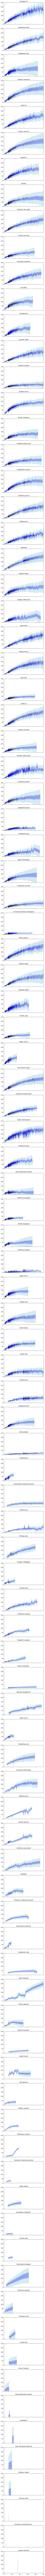

In [17]:
fig, axs = plt.subplots(
    nrows=len(results), ncols=1, figsize=(6, len(results) * 4), sharex=True, sharey=True
)

i = 0
for spp, count in (
    trees.groupby(by="FIA_SPCD")["TREE_CN"]
    .count()
    .sort_values(ascending=False)
    .iteritems()
):
    if spp in results:
        spp_name = lookup_fiafvs.loc[spp, "COMMON_NAME"]
        mcmc = results[spp]
        posterior = Predictive(predict_height, mcmc.get_samples(), parallel=True)

        if count > 1000:
            idx_sort = (
                trees.loc[trees.FIA_SPCD == spp, "DBH"].sample(1000).sort_values().index
            )
        else:
            idx_sort = trees.loc[trees.FIA_SPCD == spp, "DBH"].sort_values().index

        rng_key = random.PRNGKey(42)
        post_pred = posterior(
            rng_key,
            locations=trees.loc[idx_sort, "LOCATION_IDX"].values,
            dbh=trees.loc[idx_sort, "DBH"].values,
        )["obs"]
        post_mean = post_pred.mean(axis=0)
        post_std = post_pred.std(axis=0)
        post_low = jnp.quantile(post_pred, q=0.05, axis=0)
        post_hi = jnp.quantile(post_pred, q=0.95, axis=0)

        axs.ravel()[i].plot(
            trees.loc[idx_sort, "DBH"].values, post_mean, color="blue", lw=0.5
        )
        axs.ravel()[i].fill_between(
            trees.loc[idx_sort, "DBH"].values,
            post_mean - post_std / 2,
            post_mean + post_std / 2.0,
            color="blue",
            alpha=0.5,
        )
        axs.ravel()[i].fill_between(
            trees.loc[idx_sort, "DBH"].values,
            post_low,
            post_hi,
            color="lightblue",
            alpha=0.5,
        )
        axs.ravel()[i].scatter(
            trees.loc[idx_sort, "DBH"].values,
            trees.loc[idx_sort, "HT"].values,
            s=0.5,
            color="black",
            alpha=0.5,
        )
        axs.ravel()[i].set(xlim=(0, 50), ylim=(0, 250), title=spp_name)
        i += 1

plt.show()

In [18]:
locations = np.unique(trees["LOCATION"])
locations

array([113, 312, 402, 417, 501, 502, 503, 504, 505, 506, 507, 508, 509,
       510, 511, 512, 513, 514, 515, 516, 517, 518, 601, 602, 603, 604,
       605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617,
       618, 619, 620, 621, 699, 702, 703, 705, 708, 709, 710, 711, 712,
       800])

In [19]:
param_df = pd.DataFrame(columns=["FIA_SPCD", "COMMON_NAME", "VARIABLE", *locations])
i = 0
for spp in results.keys():
    spp_name = lookup_fiafvs.loc[spp, "COMMON_NAME"]
    samples = results[spp].get_samples(1000)
    for var in ["b0", "b1", "b2"]:
        param_df.loc[i] = (
            spp,
            spp_name,
            var,
            *np.array(samples[var].mean(axis=(0, 1))),
        )
        i += 1
param_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 296
Data columns (total 55 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   FVS_SPP   297 non-null    int64  
 1   VARIABLE  297 non-null    object 
 2   113       297 non-null    float32
 3   312       297 non-null    float32
 4   402       297 non-null    float32
 5   417       297 non-null    float32
 6   501       297 non-null    float32
 7   502       297 non-null    float32
 8   503       297 non-null    float32
 9   504       297 non-null    float32
 10  505       297 non-null    float32
 11  506       297 non-null    float32
 12  507       297 non-null    float32
 13  508       297 non-null    float32
 14  509       297 non-null    float32
 15  510       297 non-null    float32
 16  511       297 non-null    float32
 17  512       297 non-null    float32
 18  513       297 non-null    float32
 19  514       297 non-null    float32
 20  515       297 non-null    float3

In [20]:
params = pd.pivot(
    pd.melt(
        param_df,
        id_vars=["FIA_SPCD", "COMMON_NAME", "VARIABLE"],
        value_vars=locations,
        var_name="LOCATION",
    ),
    index=["FIA_SPCD", "COMMON_NAME", "LOCATION"],
    columns=["VARIABLE"],
    values="value",
)
params.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5247 entries, (11, 113) to (999, 800)
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   b0      5247 non-null   float32
 1   b1      5247 non-null   float32
 2   b2      5247 non-null   float32
dtypes: float32(3)
memory usage: 77.1 KB


/home/ddiaz/miniconda3/envs/refit_fvs/lib/python3.10/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [21]:
params.head()

VARIABLE                  b0        b1        b2
FVS_SPP LOCATION                                
11      113       140.934921  0.083176  1.706812
        312       141.037445  0.082774  1.701991
        402       140.959808  0.082525  1.706227
        417       141.083282  0.082932  1.694801
        501       141.024078  0.082722  1.706375

In [22]:
params.to_csv(
    "../../data/interim/ht_diam_coefs_chapman_richards.csv", index=True, header=True
)